In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set timezone for date handling
# ist = pytz.timezone('Asia/Kolkata')

Mounted at /content/drive


In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Crypto-data-v2/Solana_Price_data.csv')

# Convert to datetime with correct timezone
# df['date'] = pd.to_datetime(df['date'], dayfirst=True).dt.tz_localize(ist)
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Sort chronologically
df = df.sort_values('date').reset_index(drop=True)
df['Volume'] = df['Volume'].astype(float)



In [ ]:

# Save raw version
df.to_csv('/content/drive/MyDrive/Crypto-data-v2/1_raw_data.csv', index=False)

In [ ]:
# 1.2 Verify data types
print("Data Types:")
print(df.dtypes)
print("\n")

Data Types:
date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object




In [ ]:
print("Time Period Coverage:")
print(f"Start Date: {df['date'].min()}")
print(f"End Date: {df['date'].max()}")
print(f"Total Days: {df.shape[0]}")
print(f"Expected Days: {pd.to_datetime(df['date'].max()) - pd.to_datetime(df['date'].min())}")
print("\n")

Time Period Coverage:
Start Date: 2021-01-01 00:00:00
End Date: 2025-04-15 00:00:00
Total Days: 1566
Expected Days: 1565 days 00:00:00




In [ ]:
# 1.4 Examine basic statistics
print("Basic Statistics:")
print(df.describe())

Basic Statistics:
                                date         Open         High          Low  \
count                           1566  1566.000000  1566.000000  1566.000000   
mean   2023-02-22 11:59:59.999999744    86.679205    90.334138    82.992892   
min              2021-01-01 00:00:00     1.510000     1.865000     1.495000   
25%              2022-01-27 06:00:00    23.970000    24.932500    22.935000   
50%              2023-02-22 12:00:00    56.845000    59.470000    53.790000   
75%              2024-03-19 18:00:00   144.467500   149.702500   139.587500   
max              2025-04-15 00:00:00   261.970000   295.830000   252.690000   
std                              NaN    69.515905    72.111304    66.729900   

             Close        Volume  
count  1566.000000  1.566000e+03  
mean     86.759976  2.078157e+09  
min       1.799000  2.572255e+07  
25%      23.980000  5.006599e+08  
50%      56.940000  1.479582e+09  
75%     144.467500  2.808882e+09  
max     261.970000  3.317

In [ ]:
print("\nData Sample:")
print(df.head())


Data Sample:
        date   Open   High    Low  Close      Volume
0 2021-01-01  1.510  1.865  1.495  1.847  25722549.0
1 2021-01-02  1.847  2.012  1.752  1.799  31671064.0
2 2021-01-03  1.799  2.808  2.007  2.185  55073422.0
3 2021-01-04  2.185  2.573  2.066  2.491  59955405.0
4 2021-01-05  2.491  2.634  2.145  2.158  50555207.0


In [ ]:
# 1.6 Check for any initial NULL values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


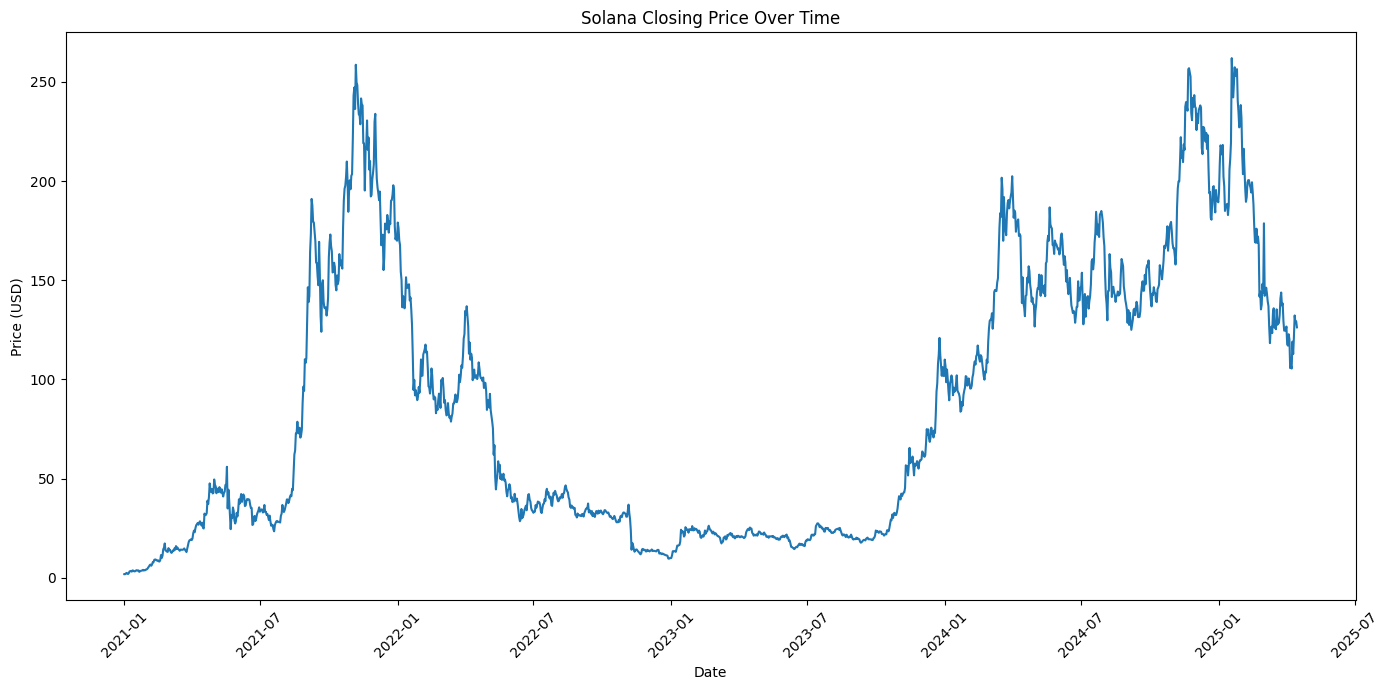

In [ ]:


# 1.7 Visualize the closing price over time to get an initial understanding
plt.figure(figsize=(14, 7))
plt.plot(df['date'], df['Close'])
plt.title('Solana Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

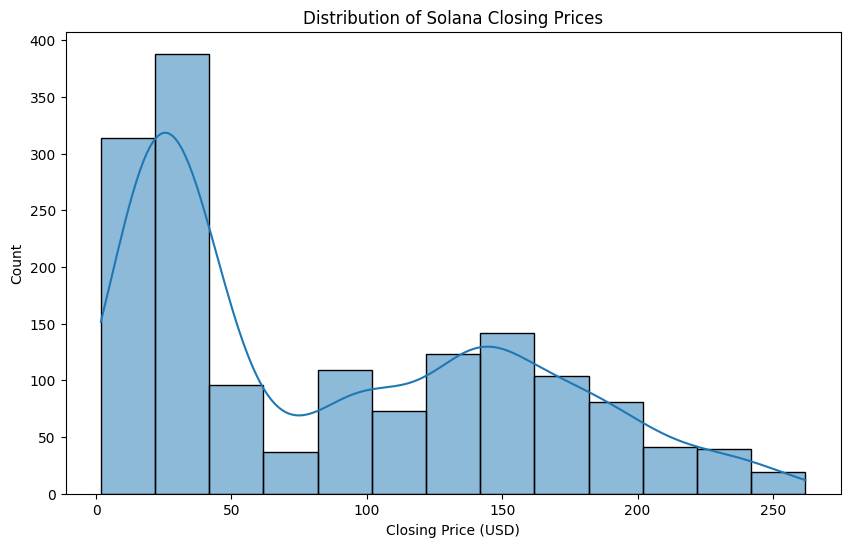

In [ ]:
# 1.8 Check the distribution of closing prices
plt.figure(figsize=(10, 6))
sns.histplot(df['Close'], kde=True)
plt.title('Distribution of Solana Closing Prices')
plt.xlabel('Closing Price (USD)')
plt.show()

In [ ]:
# 2.1. Set the datetime column as the index
df.set_index('date', inplace=True)

In [ ]:
# 2.2. Verify the index is datetime
print("Index Type:", type(df.index))
# Get information about the DatetimeIndex
print("Index Info:")
print(df.index)  # Print the index itself
print("Index Data Type:", df.index.dtype)  # Get data type of the index
print("Index Frequency:", df.index.freq)  # Check if index has a frequency
# Check if index is monotonic using alternative method for older Pandas versions
print("Index is Monotonic:", df.index.is_monotonic_increasing or df.index.is_monotonic_decreasing)
print("Index is Unique:", df.index.is_unique)  # Check if index values are unique

Index Type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index Info:
DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2025-04-06', '2025-04-07', '2025-04-08', '2025-04-09',
               '2025-04-10', '2025-04-11', '2025-04-12', '2025-04-13',
               '2025-04-14', '2025-04-15'],
              dtype='datetime64[ns]', name='date', length=1566, freq=None)
Index Data Type: datetime64[ns]
Index Frequency: None
Index is Monotonic: True
Index is Unique: True


In [ ]:
# 2.3. Sort data chronologically to ensure proper time order
df = df.sort_index()

In [ ]:
# 2.4. Check the frequency of the data
# For daily data we expect a frequency of 'D' or business day 'B'
print("\nIndex Frequency:")
if df.index.inferred_freq is not None:
    print(f"Inferred Frequency: {df.index.inferred_freq}")
else:
    print("No regular frequency detected. Checking for missing dates...")


Index Frequency:
Inferred Frequency: D


In [ ]:
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
missing_dates = full_date_range.difference(df.index)

if len(missing_dates) > 0:
    print(f"Missing {len(missing_dates)} dates in the time series.")
    print("First few missing dates:")
    print(missing_dates[:5])
else:
    print("No missing dates detected. The time series is continuous.")

No missing dates detected. The time series is continuous.


In [ ]:
# 2.5. Check for duplicate dates
duplicates = df.index.duplicated()
if duplicates.any():
    print(f"\nFound {duplicates.sum()} duplicate dates in the index")
    print("First few duplicates:")
    print(df[df.index.duplicated(keep=False)].head())
else:
    print("\nNo duplicate dates found in the index")


No duplicate dates found in the index


In [ ]:
# 2.6. Convert timezone if needed (optional - if you want UTC or a specific timezone)
# If you want to standardize to UTC:
print("\nCurrent timezone:", df.index.tz)
df.index = df.index.tz_localize('UTC')
print("New timezone:", df.index.tz)


Current timezone: None
New timezone: UTC


In [ ]:
print("Current index (first few entries):")
print(df.index[:5])

Current index (first few entries):
DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-02 00:00:00+00:00',
               '2021-01-03 00:00:00+00:00', '2021-01-04 00:00:00+00:00',
               '2021-01-05 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', freq=None)


In [ ]:
# current_index = df.index.copy()

In [ ]:
# 2. Shift the dates forward by 1 day
# adjusted_index = current_index + pd.Timedelta(days=1)

In [ ]:
# # 4. Set the adjusted index
# df.index = adjusted_index

# # 5. Verify the correction
# print("\nCorrected index (first few entries):")
# print(df.index[:5])

In [ ]:
# If you want to standardize the time component to midnight UTC:

# df.index = pd.DatetimeIndex([idx.replace(hour=0, minute=0, second=0) for idx in df.index])

# print("\nStandardized index with midnight UTC (first few entries):")
# print(df.index[:5])


In [ ]:
# # 3. Show the adjustment effect
# print("\nAdjustment effect (first few entries):")
# for i in range(5):
#     print(f"Original: {current_index[i]} → Adjusted: {adjusted_index[i]}")

In [ ]:
df.columns = df.columns.str.strip()


In [ ]:
# 2.7. Display the updated dataframe
print("\nUpdated DataFrame with datetime index:")
print(df.head())


Updated DataFrame with datetime index:
                            Open   High    Low  Close      Volume
date                                                             
2021-01-01 00:00:00+00:00  1.510  1.865  1.495  1.847  25722549.0
2021-01-02 00:00:00+00:00  1.847  2.012  1.752  1.799  31671064.0
2021-01-03 00:00:00+00:00  1.799  2.808  2.007  2.185  55073422.0
2021-01-04 00:00:00+00:00  2.185  2.573  2.066  2.491  59955405.0
2021-01-05 00:00:00+00:00  2.491  2.634  2.145  2.158  50555207.0


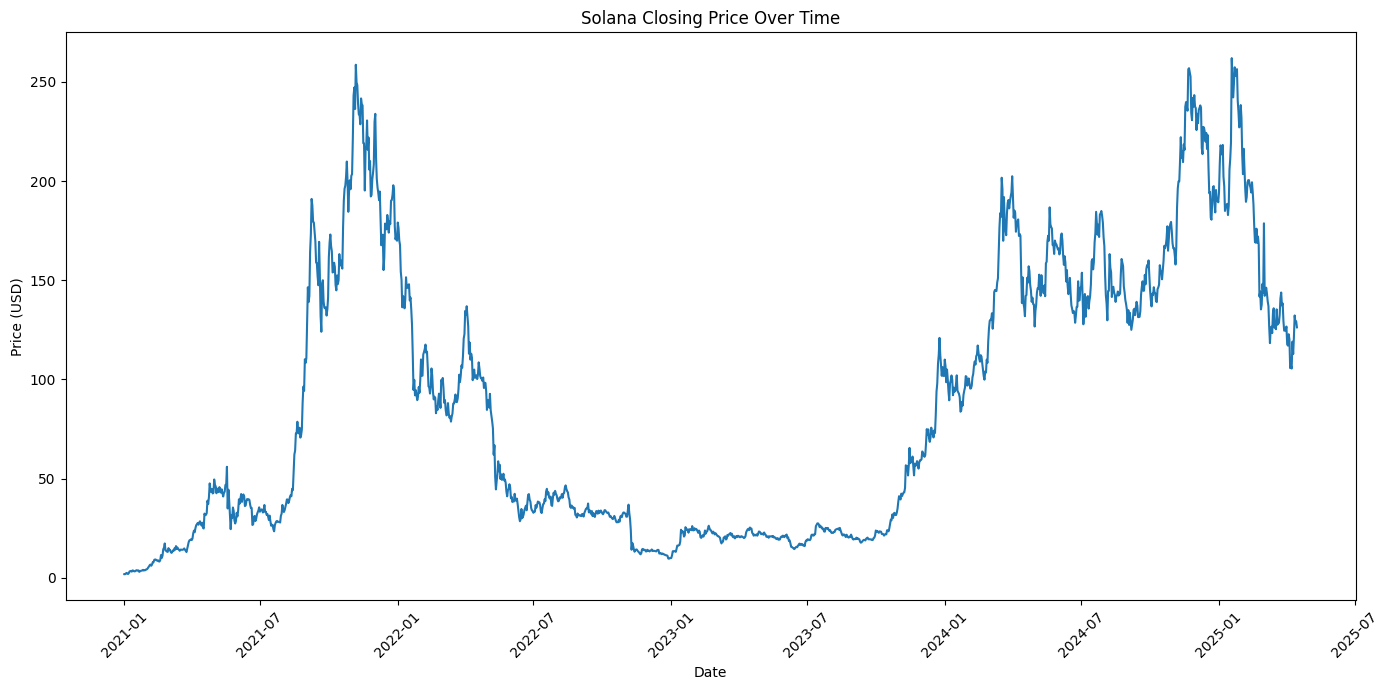

In [ ]:
# 2.8. Visualize the closing price with proper datetime index
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'])
plt.title('Solana Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv('/content/drive/MyDrive/Crypto-data-v2/step2_handling-time-index_data.csv', index=True)
# df_new = pd.read_csv('/content/drive/MyDrive/Crypto-data-v2/step2_handling-time-index_data.csv')

In [ ]:
print("\nCurrent timezone:", df.index.tz)


Current timezone: UTC


In [ ]:
df.head()

,Open,High,Low,Close,Volume
date,,,,,
2021-01-01 00:00:00+00:00,1.510,1.865,1.495,1.847,25722549.0
2021-01-02 00:00:00+00:00,1.847,2.012,1.752,1.799,31671064.0
2021-01-03 00:00:00+00:00,1.799,2.808,2.007,2.185,55073422.0
2021-01-04 00:00:00+00:00,2.185,2.573,2.066,2.491,59955405.0
2021-01-05 00:00:00+00:00,2.491,2.634,2.145,2.158,50555207.0


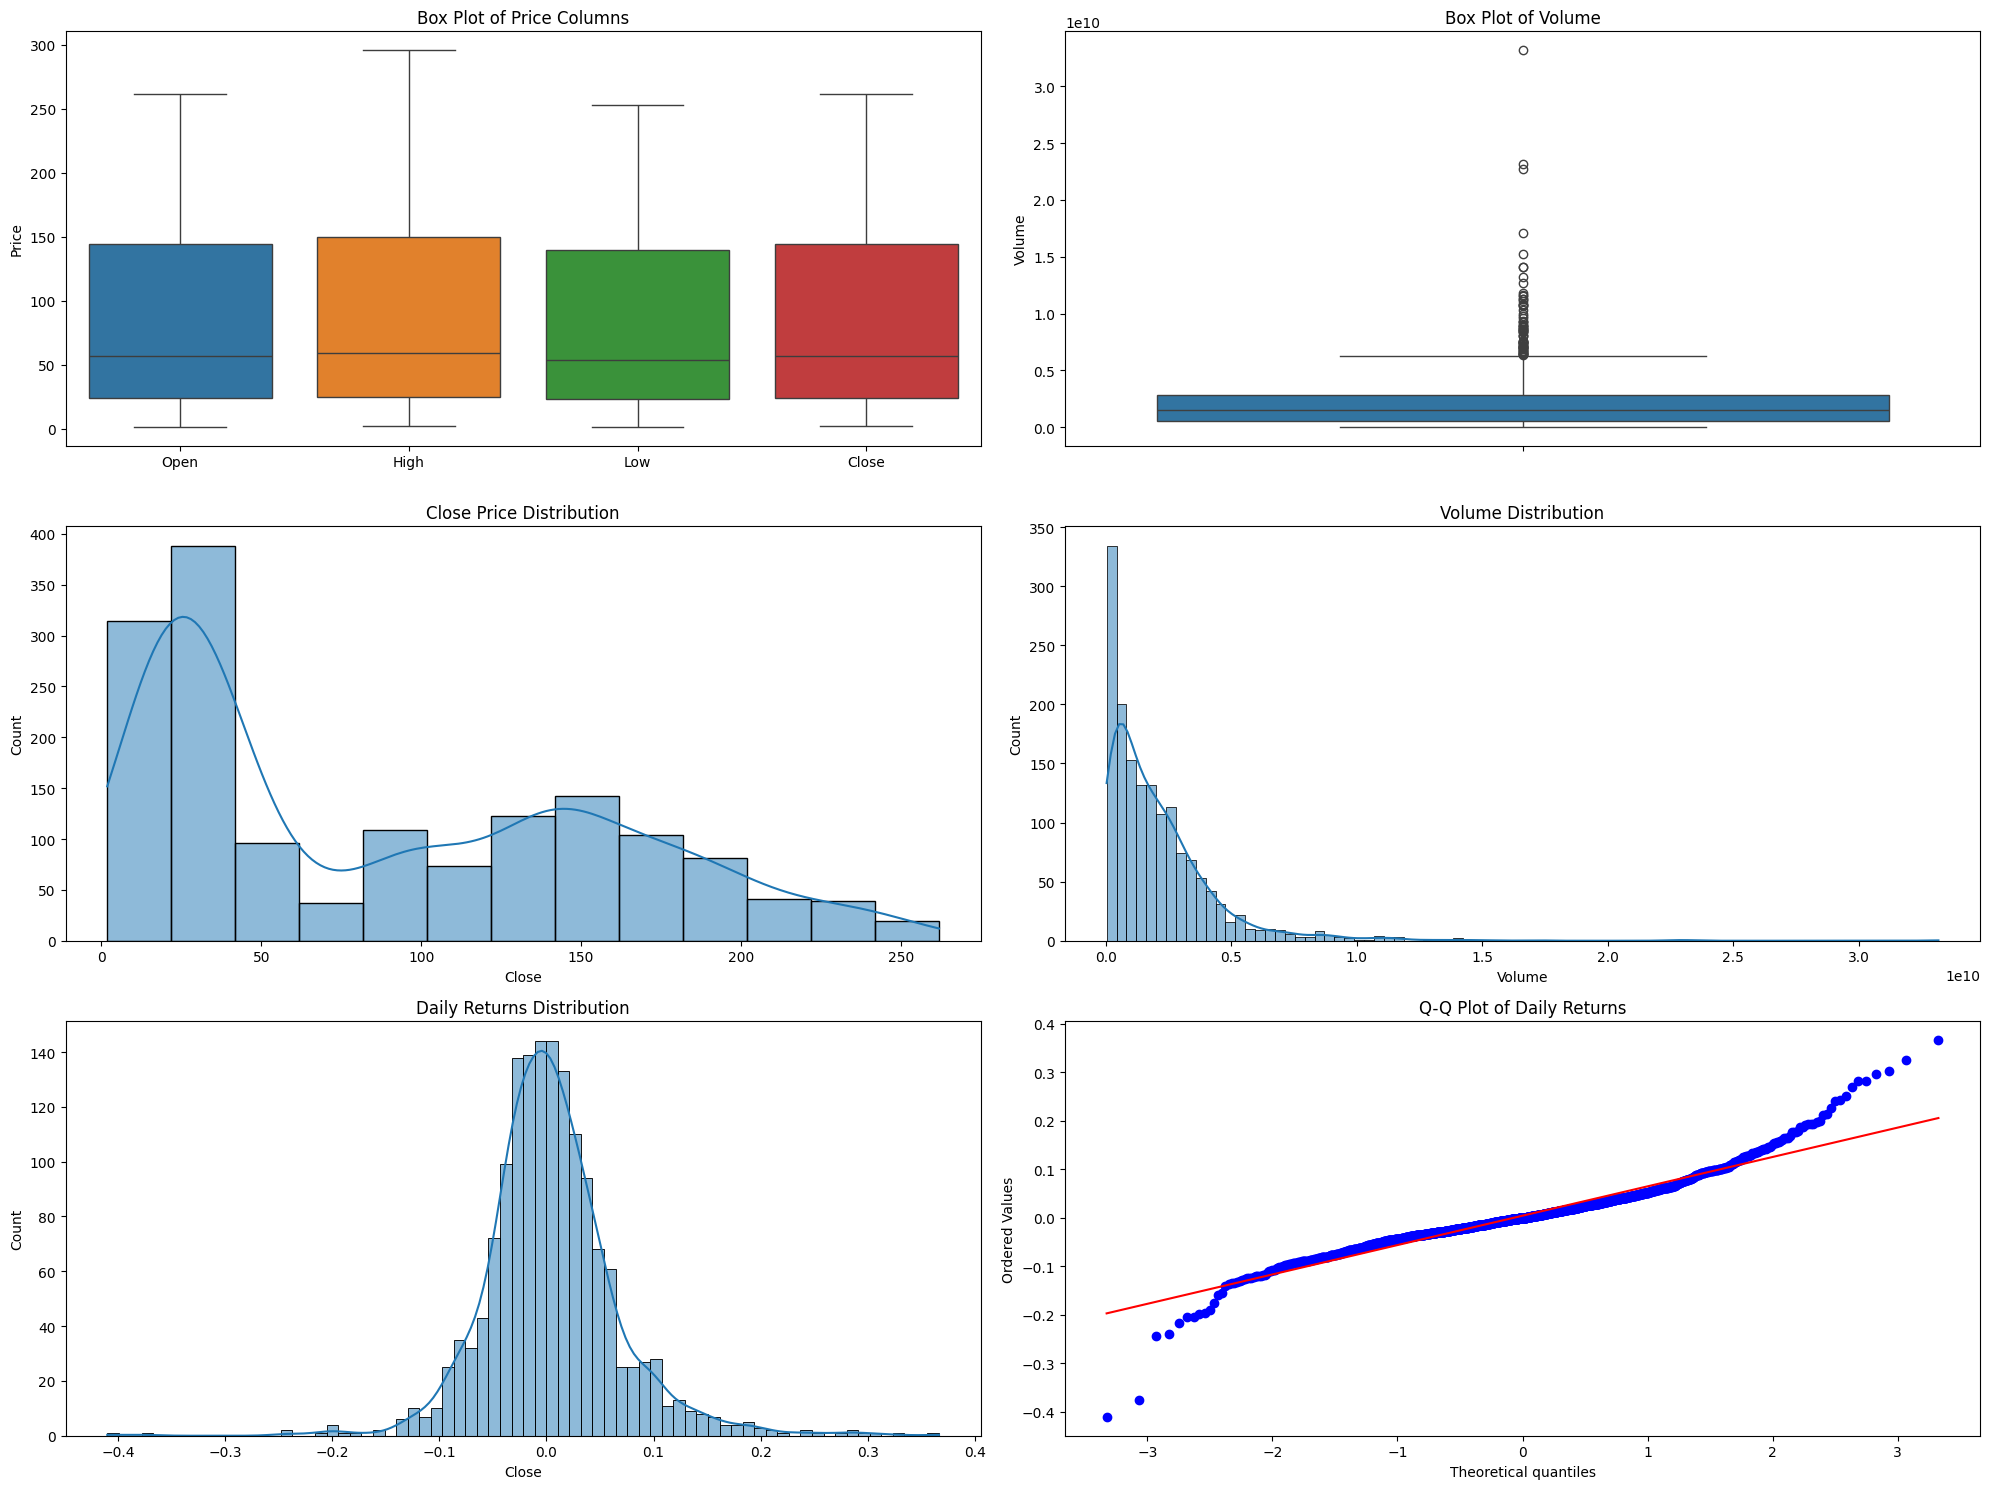

In [ ]:
# 4.1. Visualization-based outlier detection
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# Box plots for each price column
sns.boxplot(data=df[['Open', 'High', 'Low', 'Close']], ax=axes[0, 0])
axes[0, 0].set_title('Box Plot of Price Columns')
axes[0, 0].set_ylabel('Price')

# Box plot for volume
sns.boxplot(y=df['Volume'], ax=axes[0, 1])
axes[0, 1].set_title('Box Plot of Volume')
axes[0, 1].set_ylabel('Volume')

# Histogram for Close price
sns.histplot(df['Close'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Close Price Distribution')

# Histogram for Volume
sns.histplot(df['Volume'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Volume Distribution')

# Daily price changes (returns)
daily_returns = df['Close'].pct_change().dropna()
sns.histplot(daily_returns, kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Daily Returns Distribution')

# QQ plot for returns
stats.probplot(daily_returns, plot=axes[2, 1])
axes[2, 1].set_title('Q-Q Plot of Daily Returns')

plt.tight_layout()
plt.show()


In [ ]:
# 4.2. Statistical-based outlier detection

# 4.2.1. Z-Score Method
print("\n----- Z-Score Method -----")
# Calculate z-scores for price and volume
z_scores = {}
for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
    z_scores[column] = np.abs(stats.zscore(df[column]))

    # Identify outliers (typically |z| > 3)
    outliers = df[z_scores[column] > 3]
    print(f"Z-Score outliers in {column}: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

    if len(outliers) > 0:
        print("First few outliers:")
        print(outliers.head())
        print("\n")

# 4.2.2. IQR Method
print("\n----- IQR Method -----")
outliers_iqr = pd.DataFrame()

for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    column_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"IQR outliers in {column}: {len(column_outliers)} ({len(column_outliers)/len(df)*100:.2f}%)")

    if len(column_outliers) > 0:
        print(f"Range for {column}: [{lower_bound:.2f}, {upper_bound:.2f}]")
        print("First few outliers:")
        print(column_outliers.head())
        print("\n")

        # Store outliers for potential treatment
        if column_outliers.shape[0] > 0:
            if outliers_iqr.empty:
                outliers_iqr = column_outliers.copy()
            else:
                outliers_iqr = pd.concat([outliers_iqr, column_outliers])
                outliers_iqr = outliers_iqr[~outliers_iqr.index.duplicated(keep='first')]

# 4.2.3. Modified Z-Score (more robust to outliers)
print("\n----- Modified Z-Score Method -----")
for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
    # Calculate median and MAD (Median Absolute Deviation)
    median = df[column].median()
    mad = np.median(np.abs(df[column] - median))

    # Calculate modified z-scores
    if mad > 0:  # Avoid division by zero
        modified_z_scores = 0.6745 * np.abs(df[column] - median) / mad
        outliers = df[modified_z_scores > 3.5]  # Threshold commonly used
        print(f"Modified Z-Score outliers in {column}: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

        if len(outliers) > 0:
            print("First few outliers:")
            print(outliers.head())
            print("\n")
    else:
        print(f"MAD for {column} is zero - cannot compute modified Z-scores")


----- Z-Score Method -----
Z-Score outliers in Open: 0 (0.00%)
Z-Score outliers in High: 0 (0.00%)
Z-Score outliers in Low: 0 (0.00%)
Z-Score outliers in Close: 0 (0.00%)
Z-Score outliers in Volume: 26 (1.66%)
First few outliers:
                             Open    High     Low   Close        Volume
date                                                                   
2021-09-07 00:00:00+00:00  164.31  194.96  131.78  173.20  1.706864e+10
2021-09-08 00:00:00+00:00  173.20  197.94  146.72  191.01  1.318721e+10
2021-09-09 00:00:00+00:00  191.01  215.85  179.40  187.70  1.267627e+10
2024-03-15 00:00:00+00:00  176.64  188.85  164.95  183.84  1.409335e+10
2024-03-16 00:00:00+00:00  183.84  197.80  176.91  181.95  1.179413e+10



----- IQR Method -----
IQR outliers in Open: 0 (0.00%)
IQR outliers in High: 0 (0.00%)
IQR outliers in Low: 0 (0.00%)
IQR outliers in Close: 0 (0.00%)
IQR outliers in Volume: 70 (4.47%)
Range for Volume: [-2961673787.00, 6271216009.00]
First few outliers:
      

In [ ]:
# 4.3. Domain-specific outlier detection for cryptocurrencies
print("\n----- Domain-Specific Methods -----")

# 4.3.1. Extreme price jumps (daily returns)
print("\n----- Extreme Price Jumps -----")
daily_returns = df['Close'].pct_change()
extreme_returns = df[np.abs(daily_returns) > 0.20]  # 20% daily move is often considered extreme
print(f"Days with >20% price movement: {len(extreme_returns)} ({len(extreme_returns)/len(df)*100:.2f}%)")
if len(extreme_returns) > 0:
    print("First few extreme movements:")
    print(extreme_returns.head())

# 4.3.2. Trading volume spikes
print("\n----- Volume Spikes -----")
# Calculate rolling average volume (20-day)
df['Rolling_Volume_20d'] = df['Volume'].rolling(window=20).mean()

# Find days where volume exceeded 3x the rolling average
volume_spikes = df[df['Volume'] > 3 * df['Rolling_Volume_20d']].dropna()
print(f"Volume spike days: {len(volume_spikes)} ({len(volume_spikes)/len(df.dropna())*100:.2f}%)")
if len(volume_spikes) > 0:
    print("First few volume spikes:")
    print(volume_spikes[['Volume', 'Rolling_Volume_20d']].head())


----- Domain-Specific Methods -----

----- Extreme Price Jumps -----
Days with >20% price movement: 20 (1.28%)
First few extreme movements:
                             Open    High    Low   Close       Volume
date                                                                 
2021-01-03 00:00:00+00:00   1.799   2.808  2.007   2.185   55073422.0
2021-01-07 00:00:00+00:00   1.958   2.652  1.939   2.360  159870278.0
2021-01-08 00:00:00+00:00   2.360   3.815  2.182   3.225  206412154.0
2021-02-19 00:00:00+00:00   8.967  11.540  8.562  11.490  261175711.0
2021-02-22 00:00:00+00:00  11.120  14.670  9.420  14.410  574136241.0

----- Volume Spikes -----
Volume spike days: 26 (1.68%)
First few volume spikes:
                                 Volume  Rolling_Volume_20d
date                                                       
2021-02-22 00:00:00+00:00  5.741362e+08        1.323687e+08
2021-02-23 00:00:00+00:00  4.852528e+08        1.541620e+08
2021-04-18 00:00:00+00:00  1.155151e+09        

In [ ]:
# 4.4. Outlier Treatment

# Create a copy of the original data for treatment demonstrations
df_treated = df.copy()


----- Outlier Treatment: Capping (Winsorization) -----
Capping 32 values in Open
Sample before/after capping:
                           Original  After Capping
date                                              
2021-01-01 00:00:00+00:00     1.510         3.4633
2021-01-02 00:00:00+00:00     1.847         3.4633
2021-01-03 00:00:00+00:00     1.799         3.4633
2021-01-04 00:00:00+00:00     2.185         3.4633
2021-01-05 00:00:00+00:00     2.491         3.4633


Capping 32 values in High
Sample before/after capping:
                           Original  After Capping
date                                              
2021-01-01 00:00:00+00:00     1.865        3.78085
2021-01-02 00:00:00+00:00     2.012        3.78085
2021-01-03 00:00:00+00:00     2.808        3.78085
2021-01-04 00:00:00+00:00     2.573        3.78085
2021-01-05 00:00:00+00:00     2.634        3.78085


Capping 32 values in Low
Sample before/after capping:
                           Original  After Capping
date       

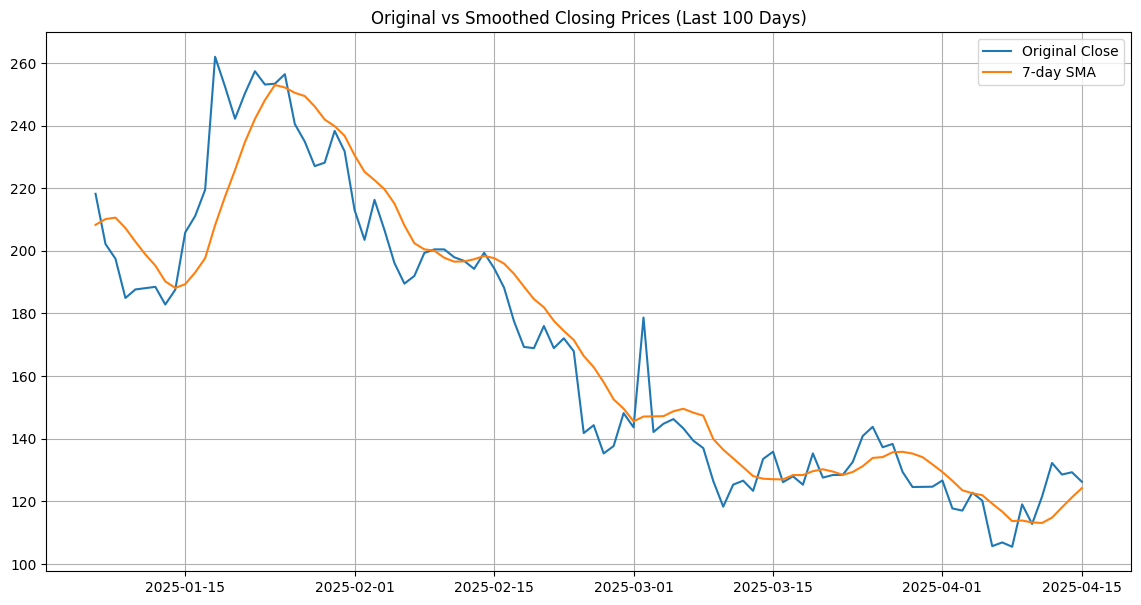


----- Outlier Treatment: Isolation Forest -----
Isolation Forest detected 79 anomalies (5.04%)
First few anomaly dates:
DatetimeIndex(['2021-01-01 00:00:00+00:00', '2021-01-02 00:00:00+00:00',
               '2021-01-03 00:00:00+00:00', '2021-01-04 00:00:00+00:00',
               '2021-01-05 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', freq=None)


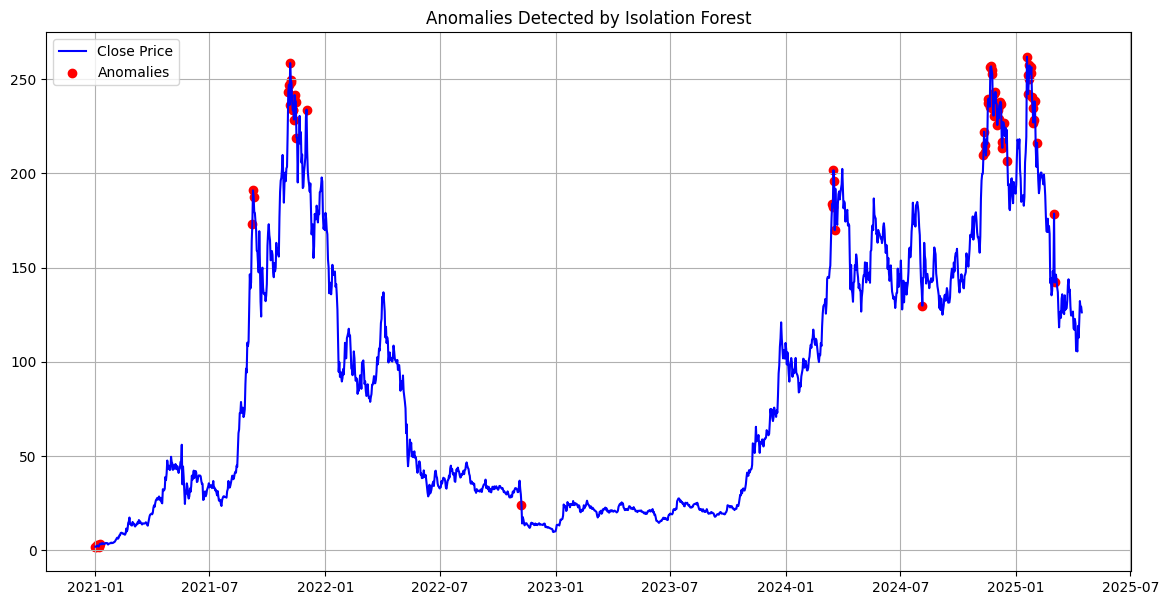

In [ ]:
# 4.4.1. Capping Method (Winsorization)
print("\n----- Outlier Treatment: Capping (Winsorization) -----")
for column in ['Open', 'High', 'Low', 'Close', 'Volume']:
    Q1 = df_treated[column].quantile(0.01)  # 1st percentile
    Q3 = df_treated[column].quantile(0.99)  # 99th percentile

    # Count values outside the range
    outliers_count = ((df_treated[column] < Q1) | (df_treated[column] > Q3)).sum()

    if outliers_count > 0:
        print(f"Capping {outliers_count} values in {column}")

        # Store original values for a sample
        sample_idx = df_treated[(df_treated[column] < Q1) | (df_treated[column] > Q3)].head().index
        original_values = df_treated.loc[sample_idx, column].copy()

        # Apply capping
        df_treated[column] = df_treated[column].clip(lower=Q1, upper=Q3)

        # Show before/after for a sample
        if len(sample_idx) > 0:
            print("Sample before/after capping:")
            comparison = pd.DataFrame({
                'Original': original_values,
                'After Capping': df_treated.loc[sample_idx, column]
            })
            print(comparison)
            print("\n")

# 4.4.2. Smoothing Method (Rolling Average)
print("\n----- Outlier Treatment: Smoothing -----")
# Create another copy for smoothing demonstration
df_smoothed = df.copy()

# Add rolling average columns
for window in [3, 7, 14]:
    for column in ['Close', 'Volume']:
        df_smoothed[f'{column}_SMA{window}'] = df_smoothed[column].rolling(window=window, center=False).mean()

# Show examples of original vs. smoothed values for potential outliers
if len(extreme_returns) > 0:
    sample_dates = extreme_returns.head().index
    print("Smoothing example for extreme price movement days:")
    smoothing_comparison = pd.DataFrame({
        'Original_Close': df_smoothed.loc[sample_dates, 'Close'],
        'SMA3': df_smoothed.loc[sample_dates, 'Close_SMA3'],
        'SMA7': df_smoothed.loc[sample_dates, 'Close_SMA7'],
        'SMA14': df_smoothed.loc[sample_dates, 'Close_SMA14'],
    })
    print(smoothing_comparison)

    # Visualize original vs smoothed data
    plt.figure(figsize=(14, 7))
    plt.plot(df_smoothed.index[-100:], df_smoothed['Close'][-100:], label='Original Close')
    plt.plot(df_smoothed.index[-100:], df_smoothed['Close_SMA7'][-100:], label='7-day SMA')
    plt.title('Original vs Smoothed Closing Prices (Last 100 Days)')
    plt.legend()
    plt.grid(True)
    plt.show()

# 4.4.3. Isolation Forest for Anomaly Detection
print("\n----- Outlier Treatment: Isolation Forest -----")
from sklearn.ensemble import IsolationForest

# Select features for anomaly detection
features = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# Fit the model
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
anomalies = isolation_forest.fit_predict(features)

# Identify the anomalies (outliers are represented by -1)
anomaly_indices = np.where(anomalies == -1)[0]
print(f"Isolation Forest detected {len(anomaly_indices)} anomalies ({len(anomaly_indices)/len(df)*100:.2f}%)")

if len(anomaly_indices) > 0:
    anomaly_dates = df.iloc[anomaly_indices].index
    print("First few anomaly dates:")
    print(anomaly_dates[:5])

    # Plot identified anomalies
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], color='blue', label='Close Price')
    plt.scatter(anomaly_dates, df.loc[anomaly_dates, 'Close'], color='red', label='Anomalies')
    plt.title('Anomalies Detected by Isolation Forest')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# 4.5. Decide which treatment to use (based on analysis)
print("\n----- Final Decision on Outlier Treatment -----")
print("Based on the above analysis, we recommend:")
print("1. For cryptocurrency data, most 'outliers' are actually significant market events")
print("2. Rather than removing them, we should consider using them as features")
print("3. For modeling, we recommend using the original data with additional features that capture:")
print("   - Volatility (e.g., rolling standard deviation)")
print("   - Extreme moves (e.g., binary flags for days with >10% moves)")
print("   - Volume spikes (e.g., ratio of volume to rolling average)")
print("4. If smoothing is necessary, consider adding smoothed features (SMAs) alongside original data")

# Add recommended features to original dataset
df['Returns'] = df['Close'].pct_change()
df['Returns_Abs'] = np.abs(df['Returns'])
df['Volatility_14d'] = df['Returns'].rolling(window=14).std()
df['Volume_Ratio'] = df['Volume'] / df['Volume'].rolling(window=20).mean()
df['Extreme_Move'] = (np.abs(df['Returns']) > 0.10).astype(int)

print("\nFinal dataset with added features:")
print(df.tail())


----- Final Decision on Outlier Treatment -----
Based on the above analysis, we recommend:
1. For cryptocurrency data, most 'outliers' are actually significant market events
2. Rather than removing them, we should consider using them as features
3. For modeling, we recommend using the original data with additional features that capture:
   - Volatility (e.g., rolling standard deviation)
   - Extreme moves (e.g., binary flags for days with >10% moves)
   - Volume spikes (e.g., ratio of volume to rolling average)
4. If smoothing is necessary, consider adding smoothed features (SMAs) alongside original data

Final dataset with added features:
                             Open    High     Low   Close        Volume  \
date                                                                      
2025-04-11 00:00:00+00:00  112.81  122.40  112.19  121.53  3.953610e+09   
2025-04-12 00:00:00+00:00  121.53  133.76  119.66  132.26  4.089398e+09   
2025-04-13 00:00:00+00:00  132.26  133.51  125.52  

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Rolling_Volume_20d,Returns,Returns_Abs,Volatility_14d,Volume_Ratio,Extreme_Move
date,,,,,,,,,,,
2021-01-01 00:00:00+00:00,1.510,1.865,1.495,1.847,25722549.0,NaN,NaN,NaN,NaN,NaN,0
2021-01-02 00:00:00+00:00,1.847,2.012,1.752,1.799,31671064.0,NaN,-0.025988,0.025988,NaN,NaN,0
2021-01-03 00:00:00+00:00,1.799,2.808,2.007,2.185,55073422.0,NaN,0.214564,0.214564,NaN,NaN,1
2021-01-04 00:00:00+00:00,2.185,2.573,2.066,2.491,59955405.0,NaN,0.140046,0.140046,NaN,NaN,1
2021-01-05 00:00:00+00:00,2.491,2.634,2.145,2.158,50555207.0,NaN,-0.133681,0.133681,NaN,NaN,1


In [ ]:
df.to_csv('/content/drive/MyDrive/Crypto-data-v2/step4_outlier-treatment.csv', index=True)

In [ ]:
!pip install ta



  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=0e92ac229ef4891a7b24e1c777e0de2e3542c37866e5d8776461c8633cce6b2a
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [ ]:
from ta import add_all_ta_features
from ta.utils import dropna
# import talib

In [ ]:
# 5.1. Create lagged features
print("Creating lagged features...")
# Create lagged price features
for lag in [1, 2, 3, 5, 7, 14, 21]:
    df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
    df[f'Volume_Lag_{lag}'] = df['Volume'].shift(lag)
    df[f'Returns_Lag_{lag}'] = df['Returns'].shift(lag)





Creating lagged features...


In [ ]:
# 5.2. Calculate moving averages
print("Calculating moving averages...")
for window in [5, 10, 20, 50, 100, 200]:
    # Simple Moving Averages
    df[f'SMA_{window}'] = df['Close'].rolling(window=window).mean()

    # Exponential Moving Averages
    df[f'EMA_{window}'] = df['Close'].ewm(span=window, adjust=False).mean()

    # Volume Moving Averages
    df[f'Volume_SMA_{window}'] = df['Volume'].rolling(window=window).mean()

Calculating moving averages...


In [ ]:
# 5.3. Calculate price momentum indicators
print("Calculating momentum indicators...")
# Rate of Change (ROC)
for period in [5, 10, 20]:
    df[f'ROC_{period}'] = df['Close'].pct_change(periods=period) * 100

# Moving Average Convergence Divergence (MACD)
df['MACD_Line'] = df['Close'].ewm(span=12, adjust=False).mean() - df['Close'].ewm(span=26, adjust=False).mean()
df['MACD_Signal'] = df['MACD_Line'].ewm(span=9, adjust=False).mean()
df['MACD_Hist'] = df['MACD_Line'] - df['MACD_Signal']

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# Williams %R
highest_high = df['High'].rolling(window=14).max()
lowest_low = df['Low'].rolling(window=14).min()
df['Williams_%R'] = ((highest_high - df['Close']) / (highest_high - lowest_low)) * -100

Calculating momentum indicators...


In [ ]:
# 5.4. Calculate volatility indicators
print("Calculating volatility indicators...")
# Bollinger Bands
for window in [20]:
    rolling_mean = df['Close'].rolling(window=window).mean()
    rolling_std = df['Close'].rolling(window=window).std()

    df[f'BB_Upper_{window}'] = rolling_mean + (rolling_std * 2)
    df[f'BB_Middle_{window}'] = rolling_mean
    df[f'BB_Lower_{window}'] = rolling_mean - (rolling_std * 2)
    df[f'BB_Width_{window}'] = (df[f'BB_Upper_{window}'] - df[f'BB_Lower_{window}']) / df[f'BB_Middle_{window}']

# Average True Range (ATR)
high_low = df['High'] - df['Low']
high_close = np.abs(df['High'] - df['Close'].shift())
low_close = np.abs(df['Low'] - df['Close'].shift())

true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['ATR_14'] = true_range.rolling(window=14).mean()

Calculating volatility indicators...


In [ ]:
# 5.5. Create cyclical features from date
print("Creating cyclical features...")
# Extract datetime components
df['Day_of_Week'] = df.index.dayofweek
df['Month'] = df.index.month
df['Quarter'] = df.index.quarter
df['Year'] = df.index.year
df['Day_of_Month'] = df.index.day
df['Week_of_Year'] = df.index.isocalendar().week

# Convert cyclical features to sine and cosine components to preserve cyclical nature
for col in ['Day_of_Week', 'Month', 'Quarter']:
    # Sine and cosine transformations
    max_val = df[col].max()
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col] / max_val)

Creating cyclical features...


In [ ]:
# 5.6. Create interaction features
print("Creating interaction features...")
# Price and volume interactions
df['Price_Volume_Ratio'] = df['Close'] / (df['Volume'] + 1)  # Adding 1 to avoid division by zero
df['Price_Volume_SMA10_Ratio'] = df['SMA_10'] / (df['Volume_SMA_10'] + 1)

# Volatility and price interactions
df['ATR_Close_Ratio'] = df['ATR_14'] / df['Close']


Creating interaction features...


In [ ]:
# 5.7. Create binary indicators
print("Creating binary indicators...")
# Golden Cross / Death Cross (50-day MA crossing 200-day MA)
df['SMA_50_Above_SMA_200'] = (df['SMA_50'] > df['SMA_200']).astype(int)
df['SMA_Golden_Cross'] = ((df['SMA_50'] > df['SMA_200']) & (df['SMA_50'].shift() <= df['SMA_200'].shift())).astype(int)
df['SMA_Death_Cross'] = ((df['SMA_50'] < df['SMA_200']) & (df['SMA_50'].shift() >= df['SMA_200'].shift())).astype(int)

# RSI Overbought/Oversold
df['RSI_Overbought'] = (df['RSI_14'] > 70).astype(int)
df['RSI_Oversold'] = (df['RSI_14'] < 30).astype(int)

# Price above/below moving averages
df['Price_Above_SMA_200'] = (df['Close'] > df['SMA_200']).astype(int)
df['Price_Above_SMA_50'] = (df['Close'] > df['SMA_50']).astype(int)

# Higher highs and lower lows (trend strength)
df['Higher_High'] = (df['High'] > df['High'].shift()).astype(int)
df['Lower_Low'] = (df['Low'] < df['Low'].shift()).astype(int)


Creating binary indicators...


In [ ]:
# 5.8. Calculate support and resistance levels
print("Calculating support and resistance levels...")
# Simple support/resistance based on recent highs and lows
df['Support_Level'] = df['Low'].rolling(window=20).min()
df['Resistance_Level'] = df['High'].rolling(window=20).max()
df['Price_to_Support_Ratio'] = df['Close'] / df['Support_Level']
df['Price_to_Resistance_Ratio'] = df['Close'] / df['Resistance_Level']

Calculating support and resistance levels...


In [ ]:
# 5.9. Add market structure features
print("Adding market structure features...")
# Calculate if price is in range or trending
df['20d_High'] = df['High'].rolling(window=20).max()
df['20d_Low'] = df['Low'].rolling(window=20).min()
df['Price_Range_Width'] = (df['20d_High'] - df['20d_Low']) / df['Close']
df['In_Range_Market'] = ((df['Price_Range_Width'] < 0.1) & (df['Volatility_14d'] < df['Volatility_14d'].rolling(window=30).mean())).astype(int)

# Calculate specific crypto-related features
# Count days since ATH (All-Time High)
df['ATH'] = df['Close'].cummax()
df['Days_Since_ATH'] = df['Close'].cummax().ne(df['Close'].cummax().shift()).cumsum()
df['ATH_Drawdown'] = (df['Close'] / df['ATH'] - 1) * 100  # Negative percentage from ATH

Adding market structure features...


In [ ]:
# 5.10. Add log-transformed features (especially useful for volume)
print("Adding log-transformed features...")
df['Log_Close'] = np.log(df['Close'])
df['Log_Volume'] = np.log(df['Volume'] + 1)  # Adding 1 to avoid log(0)

Adding log-transformed features...


Visualizing key features...


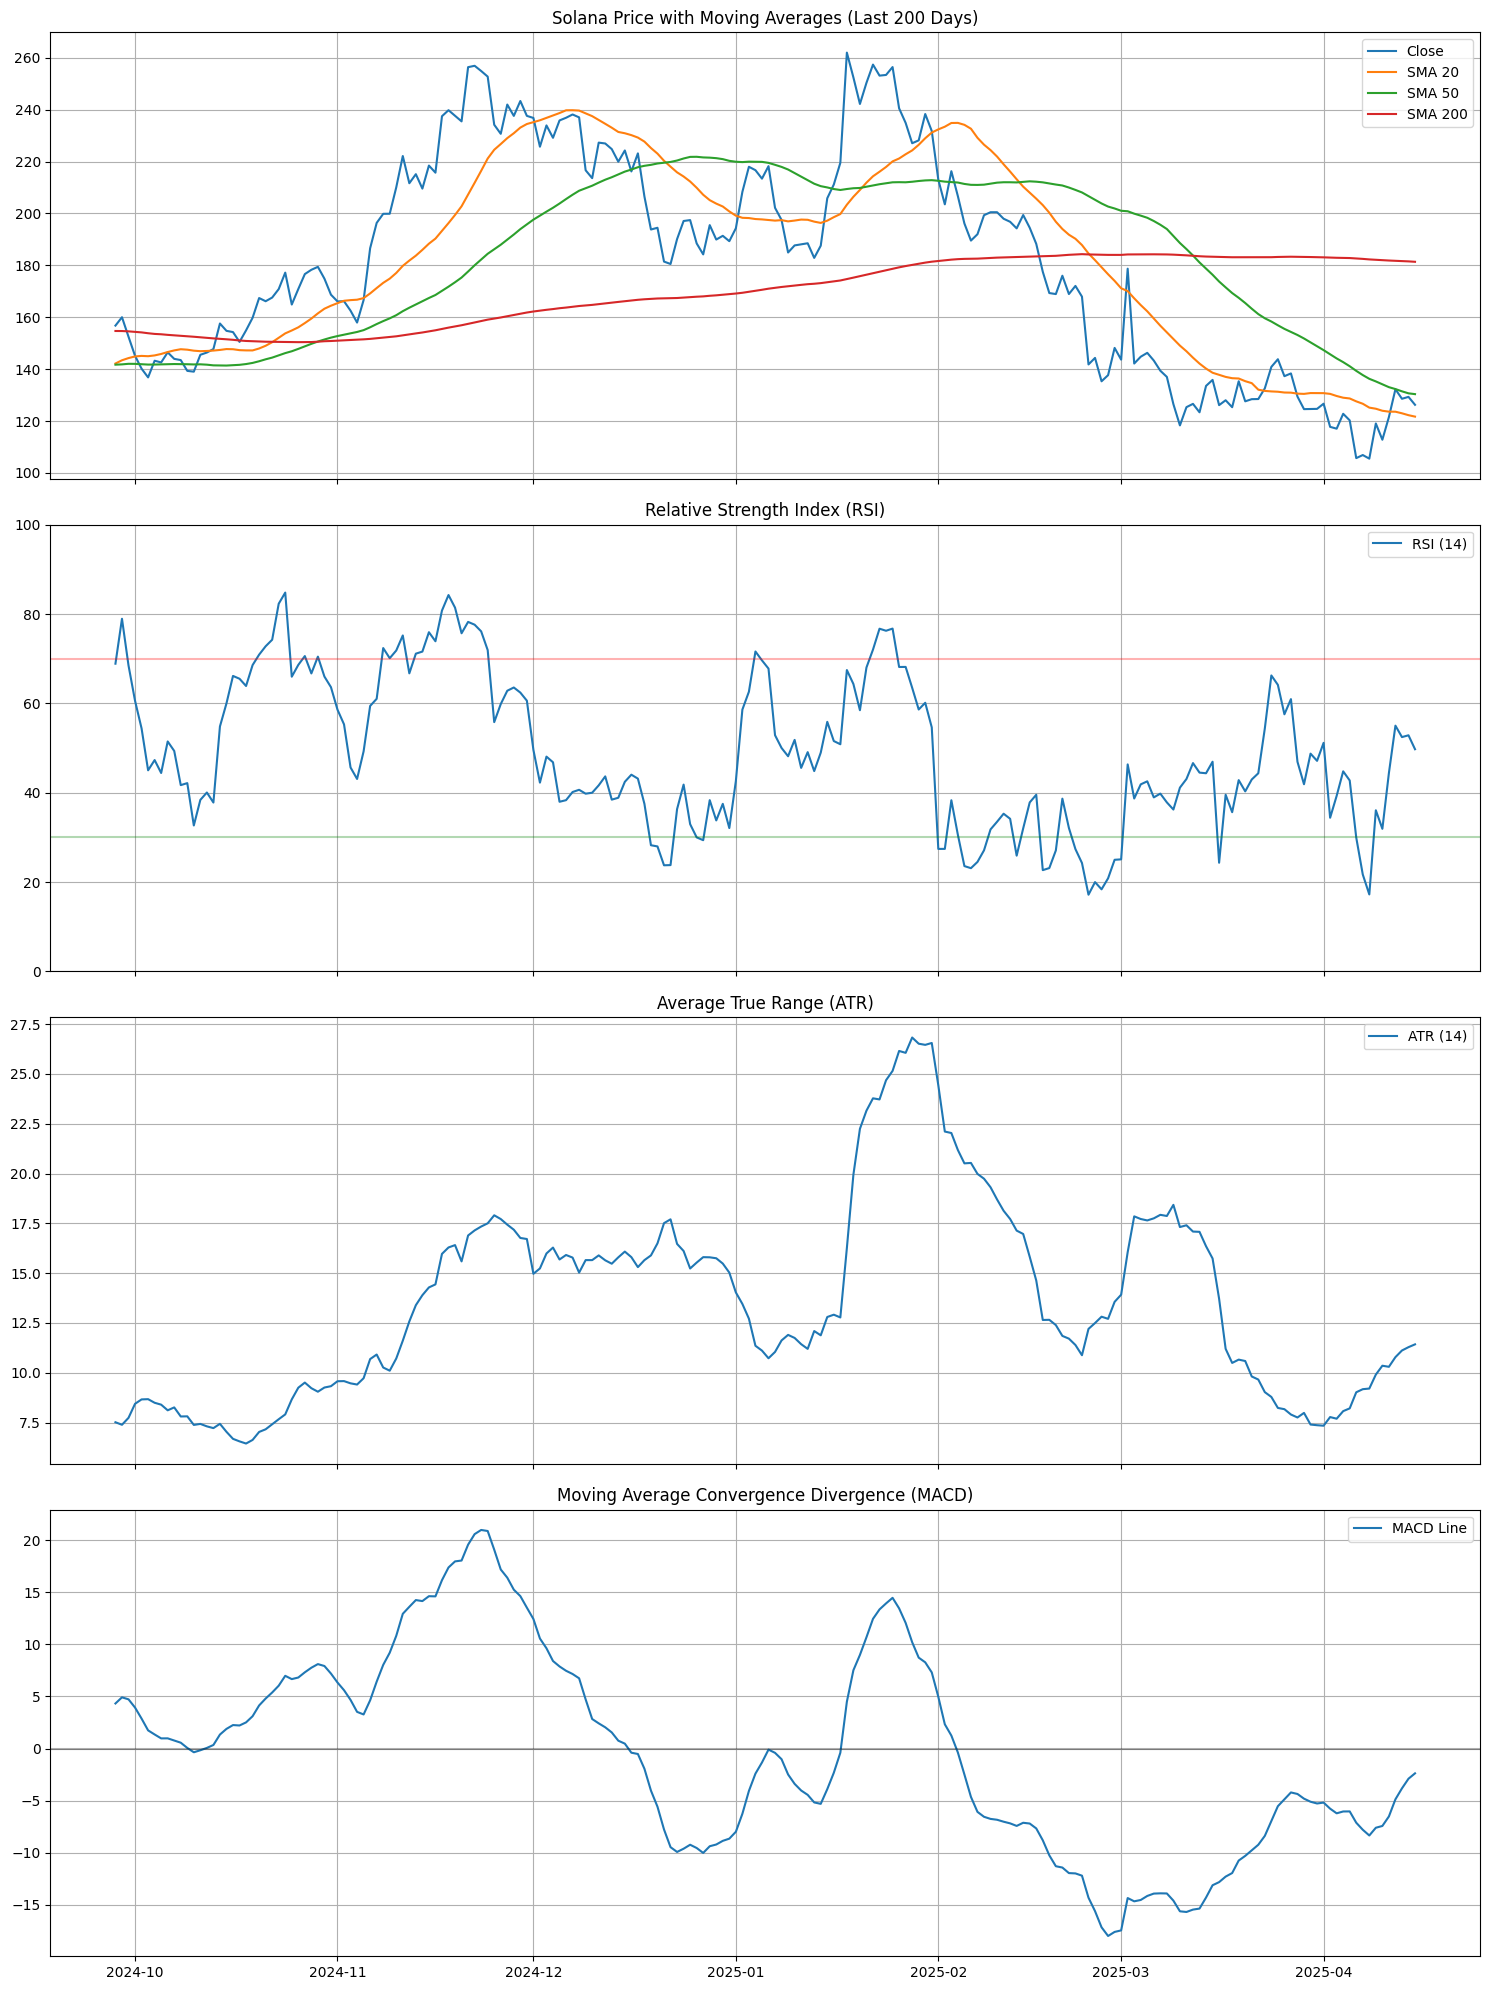

In [ ]:
# 5.11. Visualize key features
print("Visualizing key features...")
# Select a subset of important features for plotting
key_features = ['Close', 'SMA_20', 'SMA_50', 'SMA_200', 'RSI_14', 'ATR_14', 'MACD_Line']
last_200_days = df[key_features].tail(200)

# Create the plots
fig, axes = plt.subplots(4, 1, figsize=(15, 20), sharex=True)

# Plot 1: Price and Moving Averages
axes[0].plot(last_200_days.index, last_200_days['Close'], label='Close')
axes[0].plot(last_200_days.index, last_200_days['SMA_20'], label='SMA 20')
axes[0].plot(last_200_days.index, last_200_days['SMA_50'], label='SMA 50')
axes[0].plot(last_200_days.index, last_200_days['SMA_200'], label='SMA 200')
axes[0].set_title('Solana Price with Moving Averages (Last 200 Days)')
axes[0].legend()
axes[0].grid(True)

# Plot 2: RSI
axes[1].plot(last_200_days.index, last_200_days['RSI_14'], label='RSI (14)')
axes[1].axhline(y=70, color='r', linestyle='-', alpha=0.3)
axes[1].axhline(y=30, color='g', linestyle='-', alpha=0.3)
axes[1].set_title('Relative Strength Index (RSI)')
axes[1].set_ylim(0, 100)
axes[1].legend()
axes[1].grid(True)

# Plot 3: ATR
axes[2].plot(last_200_days.index, last_200_days['ATR_14'], label='ATR (14)')
axes[2].set_title('Average True Range (ATR)')
axes[2].legend()
axes[2].grid(True)

# Plot 4: MACD
axes[3].plot(last_200_days.index, last_200_days['MACD_Line'], label='MACD Line')
axes[3].axhline(y=0, color='k', linestyle='-', alpha=0.3)
axes[3].set_title('Moving Average Convergence Divergence (MACD)')
axes[3].legend()
axes[3].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 5.12. Print feature summary
print("\nFeature Engineering Summary:")
print(f"Original features: 5 (Open, High, Low, Close, Volume)")
print(f"Engineered features: {df.shape[1] - 5}")
print(f"Total features: {df.shape[1]}")

# Group features by category for better understanding
lag_features = [col for col in df.columns if 'Lag' in col]
ma_features = [col for col in df.columns if 'SMA_' in col or 'EMA_' in col]
momentum_features = [col for col in df.columns if any(x in col for x in ['RSI', 'MACD', 'ROC', 'Williams'])]
volatility_features = [col for col in df.columns if any(x in col for x in ['ATR', 'BB_', 'Volatility'])]
cyclical_features = [col for col in df.columns if any(x in col for x in ['Day_of', 'Month', 'Quarter', 'Year', 'Week_of', '_sin', '_cos'])]
binary_features = [col for col in df.columns if any(x in col for x in ['Above', 'Cross', 'Overbought', 'Oversold', 'Higher', 'Lower'])]

print(f"\nLagged features: {len(lag_features)}")
print(f"Moving average features: {len(ma_features)}")
print(f"Momentum features: {len(momentum_features)}")
print(f"Volatility features: {len(volatility_features)}")
print(f"Cyclical features: {len(cyclical_features)}")
print(f"Binary/indicator features: {len(binary_features)}")


Feature Engineering Summary:
Original features: 5 (Open, High, Low, Close, Volume)
Engineered features: 95
Total features: 100

Lagged features: 21
Moving average features: 23
Momentum features: 10
Volatility features: 7
Cyclical features: 12
Binary/indicator features: 10


In [ ]:
# 5.13. Check for any issues in the engineered features
print("\nChecking for NaN values in engineered features:")
nan_counts = df.isna().sum()
features_with_nans = nan_counts[nan_counts > 0]
print(features_with_nans)

print("\nNote: NaN values at the beginning of time series are expected due to calculation methods")
print("requiring historical data (e.g., 200-day moving averages need 200 days of data).")



Checking for NaN values in engineered features:
Rolling_Volume_20d            19
Returns                        1
Returns_Abs                    1
Volatility_14d                14
Volume_Ratio                  19
Close_Lag_1                    1
Volume_Lag_1                   1
Returns_Lag_1                  2
Close_Lag_2                    2
Volume_Lag_2                   2
Returns_Lag_2                  3
Close_Lag_3                    3
Volume_Lag_3                   3
Returns_Lag_3                  4
Close_Lag_5                    5
Volume_Lag_5                   5
Returns_Lag_5                  6
Close_Lag_7                    7
Volume_Lag_7                   7
Returns_Lag_7                  8
Close_Lag_14                  14
Volume_Lag_14                 14
Returns_Lag_14                15
Close_Lag_21                  21
Volume_Lag_21                 21
Returns_Lag_21                22
SMA_5                          4
Volume_SMA_5                   4
SMA_10                     

In [ ]:
# 5.14. Save the engineered dataset
df.to_csv('/content/drive/MyDrive/Crypto-data-v2/step5_feature_engineering.csv', index=True, index_label='date')
print("\nEngineered dataset saved as 'step5_feature_engineering.csv'")


Engineered dataset saved as 'step5_feature_engineering.csv'


In [ ]:
# 5.15. Print first few rows of the final dataset with key features
print("\nSample of final dataset with key engineered features:")
key_display_features = ['Close', 'Volume', 'Returns', 'SMA_20', 'SMA_50', 'RSI_14', 'MACD_Line', 'ATR_14']
print(df[key_display_features].head())


Sample of final dataset with key engineered features:
                           Close      Volume   Returns  SMA_20  SMA_50  \
date                                                                     
2021-01-01 00:00:00+00:00  1.847  25722549.0       NaN     NaN     NaN   
2021-01-02 00:00:00+00:00  1.799  31671064.0 -0.025988     NaN     NaN   
2021-01-03 00:00:00+00:00  2.185  55073422.0  0.214564     NaN     NaN   
2021-01-04 00:00:00+00:00  2.491  59955405.0  0.140046     NaN     NaN   
2021-01-05 00:00:00+00:00  2.158  50555207.0 -0.133681     NaN     NaN   

                           RSI_14  MACD_Line  ATR_14  
date                                                  
2021-01-01 00:00:00+00:00     NaN   0.000000     NaN  
2021-01-02 00:00:00+00:00     NaN  -0.003829     NaN  
2021-01-03 00:00:00+00:00     NaN   0.024007     NaN  
2021-01-04 00:00:00+00:00     NaN   0.069952     NaN  
2021-01-05 00:00:00+00:00     NaN   0.078588     NaN  


In [ ]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

6.1. Analyzing distributions of key features...

6.2. Applying appropriate transformations...


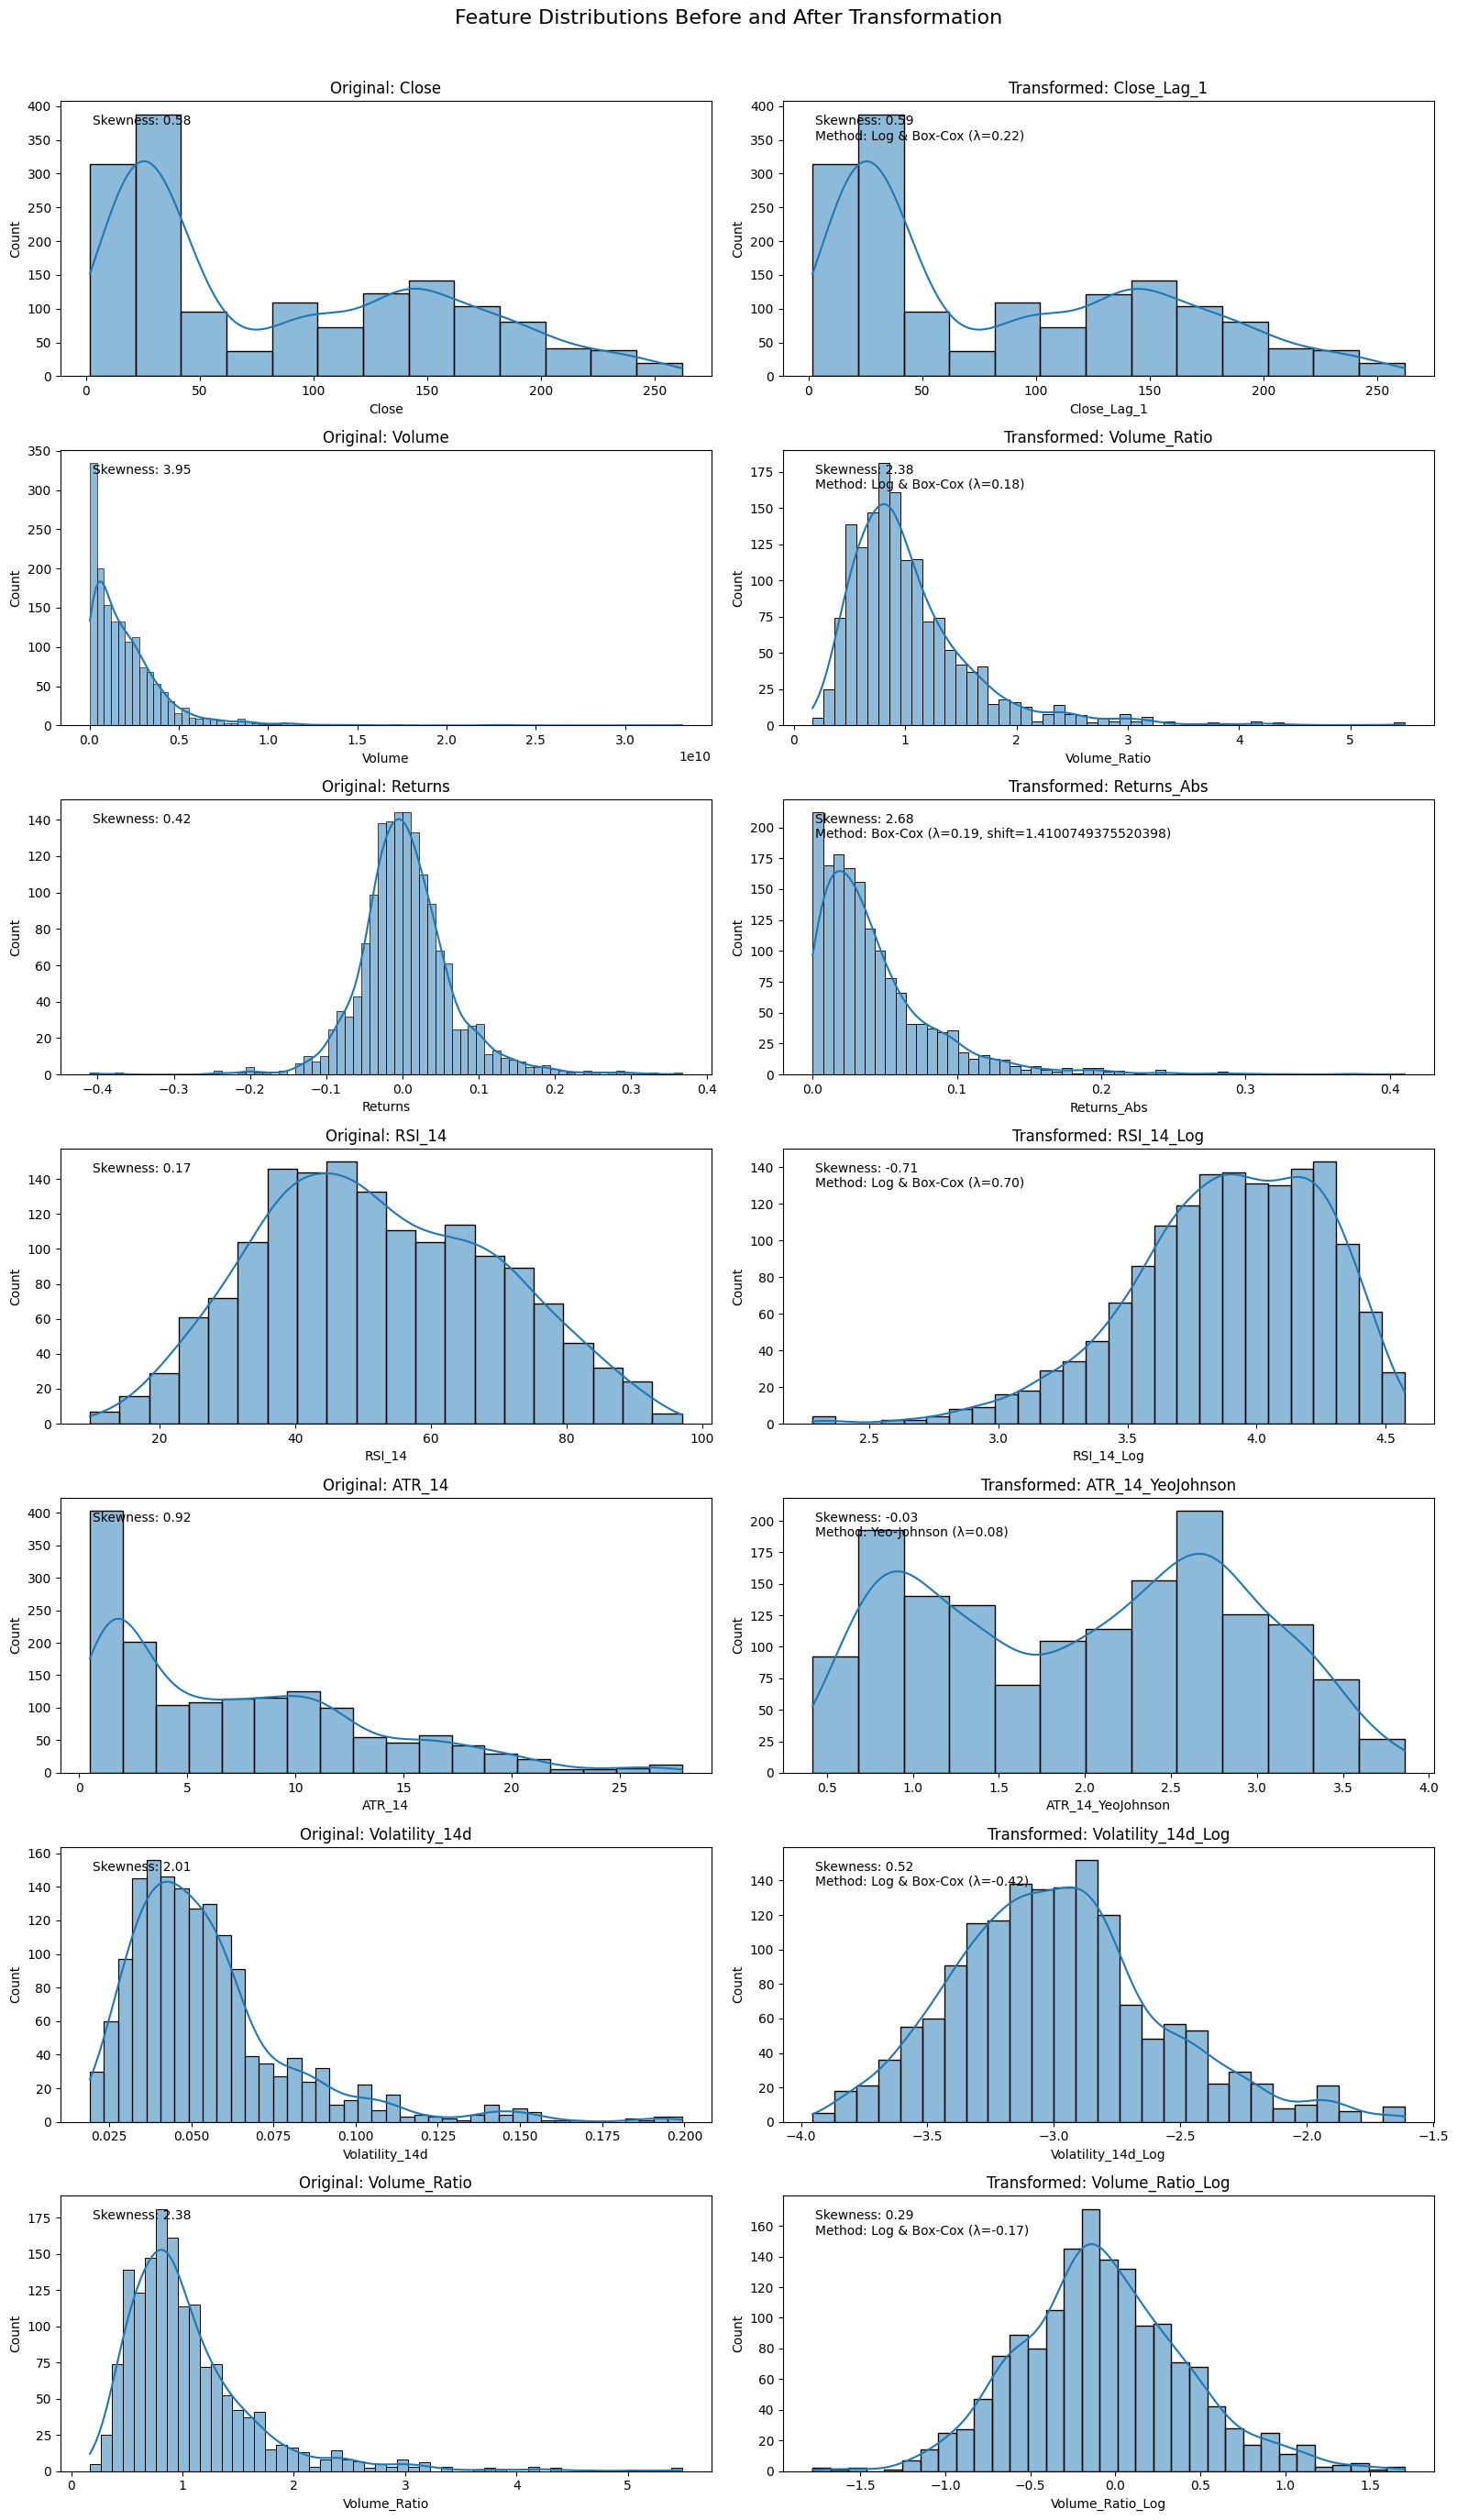

In [ ]:
# 6.1. Analyze distributions of key features
print("6.1. Analyzing distributions of key features...")

# Select key continuous features
continuous_features = ['Close', 'Volume', 'Returns', 'RSI_14', 'ATR_14', 'Volatility_14d', 'Volume_Ratio']

# Create histograms for selected features
fig, axes = plt.subplots(len(continuous_features), 2, figsize=(16, 4*len(continuous_features)))
fig.suptitle('Feature Distributions Before and After Transformation', fontsize=16)

for i, feature in enumerate(continuous_features):
    if pd.notna(df[feature]).any():  # Check if feature contains valid data
        # Original distribution
        sns.histplot(df[feature].dropna(), kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Original: {feature}')

        # Calculate skewness
        skewness = stats.skew(df[feature].dropna())
        axes[i, 0].text(0.05, 0.95, f'Skewness: {skewness:.2f}',
                  transform=axes[i, 0].transAxes,
                  verticalalignment='top')
# 6.2. Apply appropriate transformations
print("\n6.2. Applying appropriate transformations...")

# Create transformed features based on distributions
for i, feature in enumerate(continuous_features):
    if pd.notna(df[feature]).any():  # Check if feature contains valid data
        original_data = df[feature].dropna()

        # Skip features that contain negative values or zeros (for log transform)
        if feature in ['Returns', 'ATR_14'] or (original_data <= 0).any():
            # For returns, ATR, or features with negative/zero values, try Box-Cox with shift
            if (original_data <= 0).any():
                min_val = original_data.min()
                shift = abs(min_val) + 1 if min_val <= 0 else 0
                shifted_data = original_data + shift

                # For features that now have all positive values, try Box-Cox
                try:
                    transformed_data, lambda_param = stats.boxcox(shifted_data)
                    df[f'{feature}_BoxCox'] = np.nan
                    df.loc[shifted_data.index, f'{feature}_BoxCox'] = transformed_data
                    transform_type = f'Box-Cox (λ={lambda_param:.2f}, shift={shift})'
                except:
                    # If Box-Cox fails, try Yeo-Johnson
                    try:
                        transformed_data, lambda_param = stats.yeojohnson(original_data)
                        df[f'{feature}_YeoJohnson'] = np.nan
                        df.loc[original_data.index, f'{feature}_YeoJohnson'] = transformed_data
                        transform_type = f'Yeo-Johnson (λ={lambda_param:.2f})'
                    except:
                        # If all fails, try simple standardization
                        z_scores = stats.zscore(original_data)
                        df[f'{feature}_ZScore'] = np.nan
                        df.loc[original_data.index, f'{feature}_ZScore'] = z_scores
                        transform_type = 'Z-Score'
            else:
                # Try Yeo-Johnson for data with no transformation issues
                try:
                    transformed_data, lambda_param = stats.yeojohnson(original_data)
                    df[f'{feature}_YeoJohnson'] = np.nan
                    df.loc[original_data.index, f'{feature}_YeoJohnson'] = transformed_data
                    transform_type = f'Yeo-Johnson (λ={lambda_param:.2f})'
                except:
                    # Fall back to z-score
                    z_scores = stats.zscore(original_data)
                    df[f'{feature}_ZScore'] = np.nan
                    df.loc[original_data.index, f'{feature}_ZScore'] = z_scores
                    transform_type = 'Z-Score'
        else:
            # For strictly positive data with no zeros, try log transformation
            df[f'{feature}_Log'] = np.log(original_data)
            transform_type = 'Log'

            # Also try Box-Cox for comparison
            try:
                transformed_data, lambda_param = stats.boxcox(original_data)
                df[f'{feature}_BoxCox'] = np.nan
                df.loc[original_data.index, f'{feature}_BoxCox'] = transformed_data
                transform_type += f' & Box-Cox (λ={lambda_param:.2f})'
            except:
                pass

        # Plot transformed distribution
        transformed_col = next((col for col in df.columns if col.startswith(f'{feature}_')), None)
        if transformed_col:
            sns.histplot(df[transformed_col].dropna(), kde=True, ax=axes[i, 1])
            axes[i, 1].set_title(f'Transformed: {transformed_col}')

            # Calculate skewness of transformed data
            skewness = stats.skew(df[transformed_col].dropna())
            axes[i, 1].text(0.05, 0.95, f'Skewness: {skewness:.2f}\nMethod: {transform_type}',
                      transform=axes[i, 1].transAxes,
                      verticalalignment='top')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


6.3. Applying differencing for stationarity...

Stationarity Test Results:
ADF null hypothesis: Series has a unit root (non-stationary)
KPSS null hypothesis: Series is stationary
              Series  Differencing   ADF p-value  KPSS p-value
0              Close             0  3.727291e-01      0.010000
1         Log(Close)             0  8.591587e-02      0.010000
2       Diff1(Close)             1  3.573618e-30      0.100000
3  Diff1(Log(Close))             1  1.345065e-22      0.045256


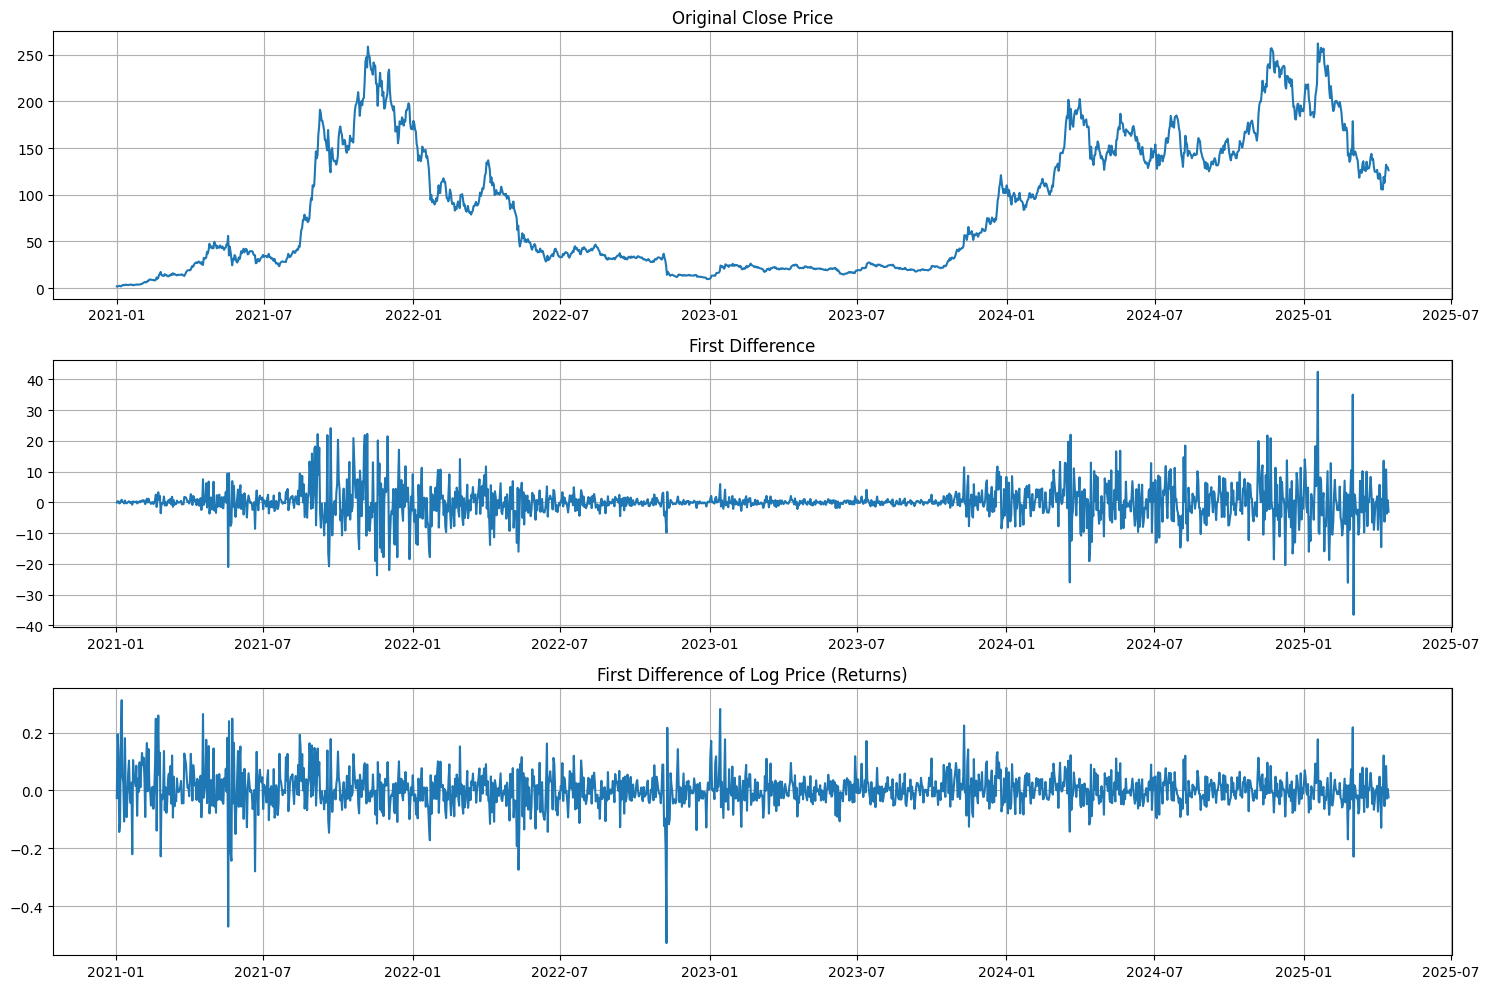

In [ ]:
# 6.3. Apply differencing for stationarity
print("\n6.3. Applying differencing for stationarity...")

# Function to test stationarity
def test_stationarity(series, title):
    # ADF Test
    result = adfuller(series.dropna())
    adf_pvalue = result[1]

    # KPSS Test
    try:
        kpss_result = kpss(series.dropna())
        kpss_pvalue = kpss_result[1]
    except:
        kpss_pvalue = None

    return adf_pvalue, kpss_pvalue

# Apply differencing and test stationarity
stationarity_results = []

# Test original Close price and log price
close_price = df['Close'].dropna()
log_close = np.log(close_price)

# Original price stationarity
adf_p, kpss_p = test_stationarity(close_price, 'Original Close Price')
stationarity_results.append(['Close', 0, adf_p, kpss_p])

# Log price stationarity
adf_p, kpss_p = test_stationarity(log_close, 'Log Close Price')
stationarity_results.append(['Log(Close)', 0, adf_p, kpss_p])

# First difference
diff1 = close_price.diff().dropna()
adf_p, kpss_p = test_stationarity(diff1, '1st Difference')
stationarity_results.append(['Diff1(Close)', 1, adf_p, kpss_p])
df['Close_Diff1'] = df['Close'].diff()

# First difference of log price (returns)
log_diff1 = log_close.diff().dropna()
adf_p, kpss_p = test_stationarity(log_diff1, '1st Difference of Log')
stationarity_results.append(['Diff1(Log(Close))', 1, adf_p, kpss_p])
df['LogClose_Diff1'] = np.log(df['Close']).diff()

# Second difference if needed
if adf_p > 0.05:
    diff2 = diff1.diff().dropna()
    adf_p, kpss_p = test_stationarity(diff2, '2nd Difference')
    stationarity_results.append(['Diff2(Close)', 2, adf_p, kpss_p])
    df['Close_Diff2'] = df['Close'].diff().diff()

# Display stationarity test results
stationarity_df = pd.DataFrame(stationarity_results,
                              columns=['Series', 'Differencing', 'ADF p-value', 'KPSS p-value'])
print("\nStationarity Test Results:")
print("ADF null hypothesis: Series has a unit root (non-stationary)")
print("KPSS null hypothesis: Series is stationary")
print(stationarity_df)

# Plot differenced series
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(close_price.index, close_price)
plt.title('Original Close Price')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(diff1.index, diff1)
plt.title('First Difference')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(log_diff1.index, log_diff1)
plt.title('First Difference of Log Price (Returns)')
plt.grid(True)

plt.tight_layout()
plt.show()


6.4. Applying time series decomposition...


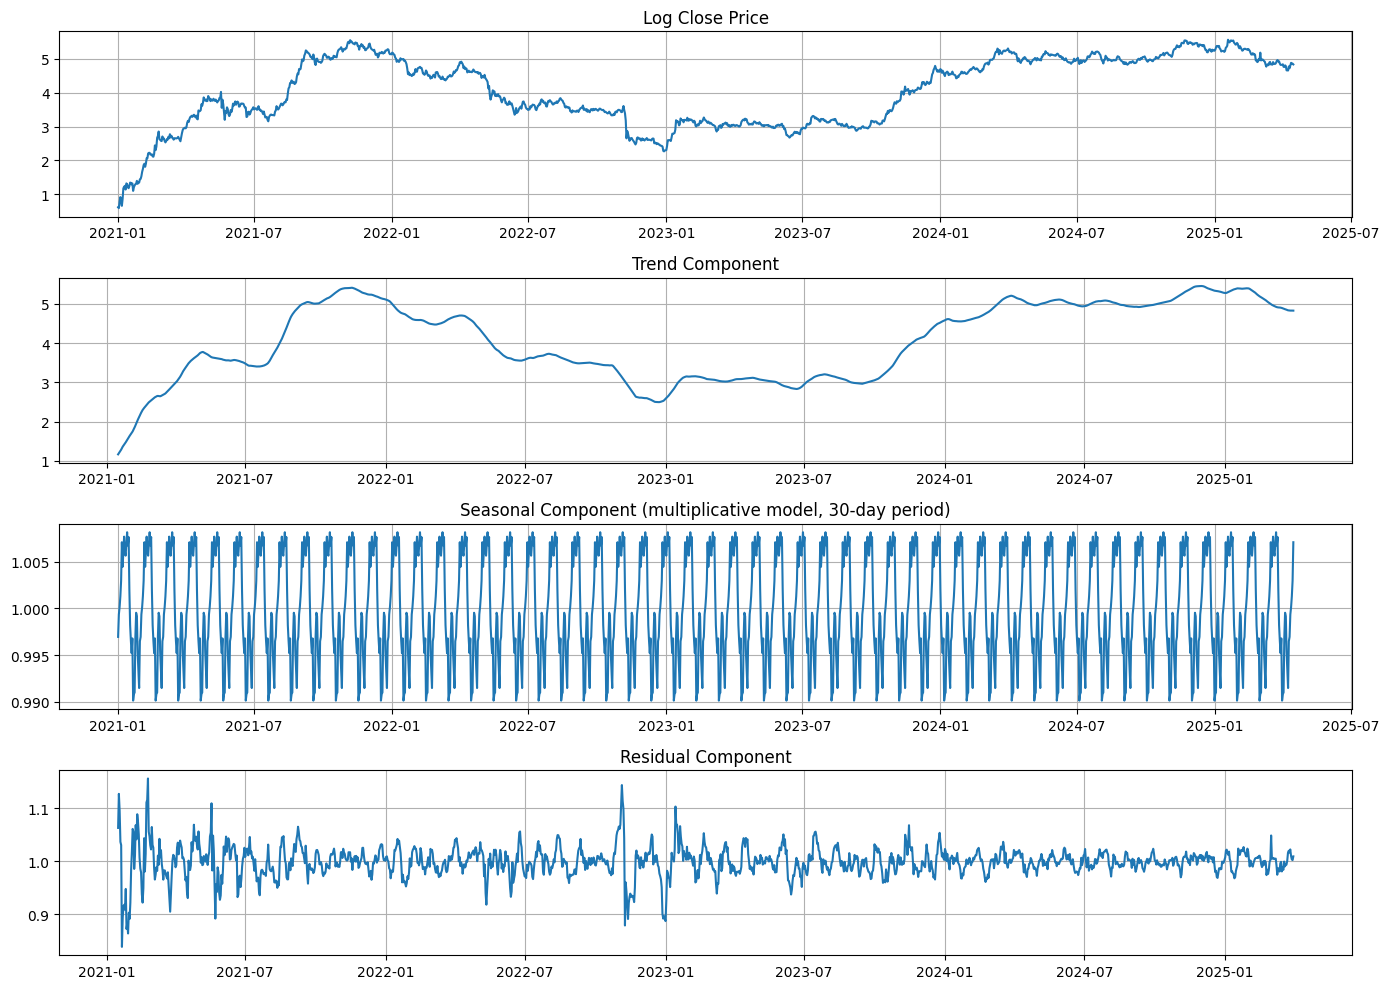

In [ ]:
# 6.4. Apply decomposition to extract components
print("\n6.4. Applying time series decomposition...")

from statsmodels.tsa.seasonal import seasonal_decompose

# We'll decompose the log close price to deal with multiplicative trends
try:
    # Try multiplicative decomposition
    decomposition = seasonal_decompose(log_close, model='multiplicative', period=30)
    model_type = 'multiplicative'
except:
    # Fall back to additive
    decomposition = seasonal_decompose(log_close, model='additive', period=30)
    model_type = 'additive'

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Add components to dataframe
df['Log_Close_Trend'] = trend
df['Log_Close_Seasonal'] = seasonal
df['Log_Close_Residual'] = residual

# Plot decomposition
plt.figure(figsize=(14, 10))
plt.subplot(4, 1, 1)
plt.plot(log_close.index, log_close)
plt.title('Log Close Price')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(trend.index, trend)
plt.title('Trend Component')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(seasonal.index, seasonal)
plt.title(f'Seasonal Component ({model_type} model, 30-day period)')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(residual.index, residual)
plt.title('Residual Component')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 6.5. Apply standardization/normalization
print("\n6.5. Applying standardization/normalization...")

# Create standardized versions of numeric features that aren't binary
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
binary_cols = [col for col in df.columns if df[col].nunique() <= 2]
numeric_non_binary = [col for col in numeric_cols if col not in binary_cols and not col.endswith(('_ZScore', '_BoxCox', '_YeoJohnson', '_Log'))]

# Z-score standardization
for col in numeric_non_binary:
    mean_val = df[col].mean()
    std_val = df[col].std()
    if std_val > 0:  # Avoid division by zero
        df[f'{col}_Zscore'] = (df[col] - mean_val) / std_val

# Min-Max scaling (0 to 1 range)
for col in numeric_non_binary:
    min_val = df[col].min()
    max_val = df[col].max()
    range_val = max_val - min_val
    if range_val > 0:  # Avoid division by zero
        df[f'{col}_MinMax'] = (df[col] - min_val) / range_val

# Robust scaling (based on IQR)
for col in numeric_non_binary:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    median = df[col].median()
    if iqr > 0:  # Avoid division by zero
        df[f'{col}_Robust'] = (df[col] - median) / iqr


6.5. Applying standardization/normalization...


In [ ]:
# 6.6. Check for and handle stationarity of transformed features
print("\n6.6. Checking stationarity of key transformed features...")

# Sample a few transformed price features for stationarity check
transformed_features = ['Close_Zscore', 'Close_MinMax', 'Close_Robust', 'Close_Diff1']

# Test and report stationarity
transformed_stationarity = []

for feature in transformed_features:
    if feature in df.columns and pd.notna(df[feature]).any():
        adf_p, kpss_p = test_stationarity(df[feature].dropna(), feature)
        transformed_stationarity.append([feature, adf_p, kpss_p])

if transformed_stationarity:
    transformed_stat_df = pd.DataFrame(transformed_stationarity,
                                    columns=['Transformed Feature', 'ADF p-value', 'KPSS p-value'])
    print("\nStationarity Test Results for Transformed Features:")
    print(transformed_stat_df)



6.6. Checking stationarity of key transformed features...

Stationarity Test Results for Transformed Features:
  Transformed Feature   ADF p-value  KPSS p-value
0        Close_Zscore  3.727291e-01          0.01
1        Close_MinMax  3.727291e-01          0.01
2        Close_Robust  3.727291e-01          0.01
3         Close_Diff1  3.573618e-30          0.10


In [ ]:
# 6.7. Summary of transformations
print("\n6.7. Summary of transformations:")
original_cols = 100  # From your previous output
transformation_cols = len([col for col in df.columns if any(suffix in col for suffix in ['_ZScore', '_BoxCox', '_YeoJohnson', '_Log', '_Diff1', '_Diff2', '_Zscore', '_MinMax', '_Robust'])])

print(f"Original number of features: {original_cols}")
print(f"Number of transformed features added: {transformation_cols}")
print(f"Total number of features after transformation: {len(df.columns)}")


6.7. Summary of transformations:
Original number of features: 100
Number of transformed features added: 276
Total number of features after transformation: 379


In [ ]:
# 6.8. Save the transformed dataset
df.to_csv('/content/drive/MyDrive/Crypto-data-v2/step6_data_transformation.csv', index=True, index_label='date')
print("\nTransformed dataset saved as 'step6_data_transformation.csv'")


Transformed dataset saved as 'step6_data_transformation.csv'


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Crypto-data-v2/step6_data_transformation.csv', parse_dates=['date'], index_col='date')

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Rolling_Volume_20d,Returns,Returns_Abs,Volatility_14d,Volume_Ratio,...,ATR_14_YeoJohnson,Volatility_14d_Log,Volatility_14d_BoxCox,Volume_Ratio_Log,Volume_Ratio_BoxCox,Close_Diff1,LogClose_Diff1,Log_Close_Trend,Log_Close_Seasonal,Log_Close_Residual
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,1.510,1.865,1.495,1.847,25722549.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996942,NaN
2021-01-02 00:00:00+00:00,1.847,2.012,1.752,1.799,31671064.0,NaN,-0.025988,0.025988,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.048,-0.026332,NaN,0.999353,NaN
2021-01-03 00:00:00+00:00,1.799,2.808,2.007,2.185,55073422.0,NaN,0.214564,0.214564,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.386,0.194385,NaN,1.000135,NaN
2021-01-04 00:00:00+00:00,2.185,2.573,2.066,2.491,59955405.0,NaN,0.140046,0.140046,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.306,0.131068,NaN,1.001296,NaN
2021-01-05 00:00:00+00:00,2.491,2.634,2.145,2.158,50555207.0,NaN,-0.133681,0.133681,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.333,-0.143502,NaN,1.002961,NaN


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

In [ ]:
print("Step 7: Feature Scaling/Normalization")

# 7.1. First, let's separate our target variable and features
# Assuming our target is the 'Close' price
target_column = 'Close'
features = df.drop(columns=[target_column])


Step 7: Feature Scaling/Normalization


In [ ]:
# 7.2. Split data chronologically into train and validation sets
# Time series requires chronological splitting - don't shuffle!
train_size = 0.8  # Use 80% of data for training
split_idx = int(len(df) * train_size)

# Split features and target
X_train = features.iloc[:split_idx]
X_valid = features.iloc[split_idx:]
y_train = df[target_column].iloc[:split_idx]
y_valid = df[target_column].iloc[split_idx:]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_valid.shape}")

Training set shape: (1252, 378)
Validation set shape: (314, 378)


In [ ]:
# 7.3. Check for columns that might cause issues during scaling
# Identify constant features (zero variance)
constant_features = [col for col in features.columns if features[col].std() == 0]
if constant_features:
    print(f"Found {len(constant_features)} constant features (zero variance). These will be removed:")
    print(constant_features[:5], "..." if len(constant_features) > 5 else "")

    # Remove constant features
    X_train = X_train.drop(columns=constant_features)
    X_valid = X_valid.drop(columns=constant_features)
    print(f"Shapes after removing constant features - Train: {X_train.shape}, Valid: {X_valid.shape}")


Found 1 constant features (zero variance). These will be removed:
['In_Range_Market'] 
Shapes after removing constant features - Train: (1252, 377), Valid: (314, 377)



7.4. Applying Standard Scaling (Z-score normalization)
Standard scaled training data statistics:
                            mean       std       min       max
Open                6.810314e-17  1.000400 -1.082840  3.235784
High                1.021547e-16  1.000400 -1.083443  3.078522
Low                 2.156599e-16  1.000400 -1.081232  3.219599
Volume             -5.675261e-17  1.000400 -0.909146  9.016200
Rolling_Volume_20d  6.915258e-17  1.000406 -1.096397  4.019226


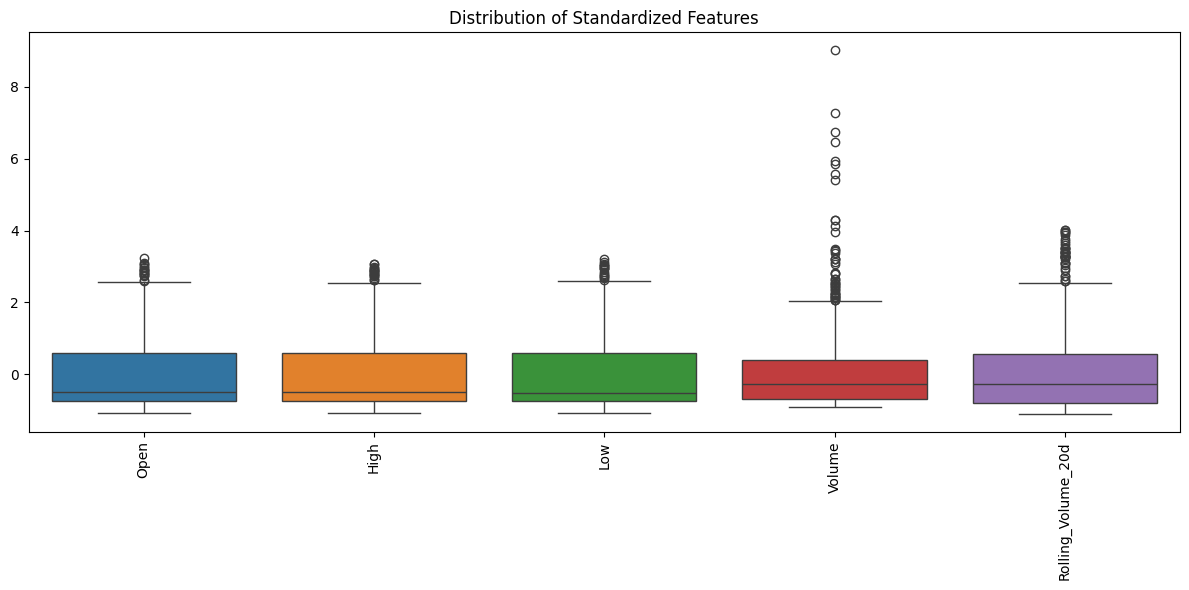

In [ ]:
# 7.4. Standard Scaling (Z-score normalization)
print("\n7.4. Applying Standard Scaling (Z-score normalization)")

# Initialize and fit scaler
std_scaler = StandardScaler()
X_train_std = pd.DataFrame(
    std_scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_valid_std = pd.DataFrame(
    std_scaler.transform(X_valid),
    columns=X_valid.columns,
    index=X_valid.index
)

# Check the scaled data
print("Standard scaled training data statistics:")
print(X_train_std.describe().T[['mean', 'std', 'min', 'max']].head())

# Visualize a sample of standardized features
plt.figure(figsize=(12, 6))
cols_to_plot = X_train_std.columns[:5]  # Just plot first 5 columns for clarity
sns.boxplot(data=X_train_std[cols_to_plot])
plt.title('Distribution of Standardized Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


7.5. Applying Min-Max Scaling
Min-max scaled training data statistics:
                        mean       std  min  max
Open                0.250737  0.231648  0.0  1.0
High                0.260320  0.240367  0.0  1.0
Low                 0.251401  0.232606  0.0  1.0
Volume              0.091598  0.100792  0.0  1.0
Rolling_Volume_20d  0.214323  0.195559  0.0  1.0


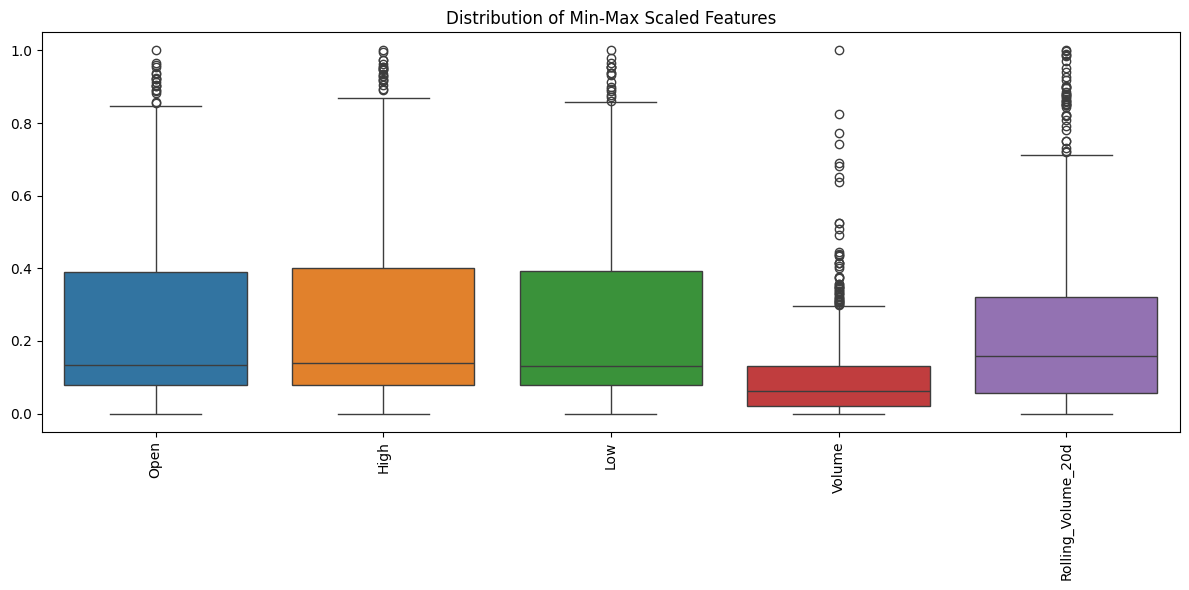

In [ ]:
# 7.5. Min-Max Scaling
print("\n7.5. Applying Min-Max Scaling")

# Initialize and fit scaler
minmax_scaler = MinMaxScaler()
X_train_minmax = pd.DataFrame(
    minmax_scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_valid_minmax = pd.DataFrame(
    minmax_scaler.transform(X_valid),
    columns=X_valid.columns,
    index=X_valid.index
)

# Check the scaled data
print("Min-max scaled training data statistics:")
print(X_train_minmax.describe().T[['mean', 'std', 'min', 'max']].head())

# Visualize a sample of min-max scaled features
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train_minmax[cols_to_plot])
plt.title('Distribution of Min-Max Scaled Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



7.6. Applying Robust Scaling
Robust scaled training data statistics:
                        mean       std       min       max
Open                0.376238  0.747482 -0.432843  2.793964
High                0.377947  0.749081 -0.433315  2.683089
Low                 0.382406  0.746211 -0.424099  2.783947
Volume              0.261436  0.914169 -0.569344  8.500470
Rolling_Volume_20d  0.211879  0.739382 -0.598448  3.182418


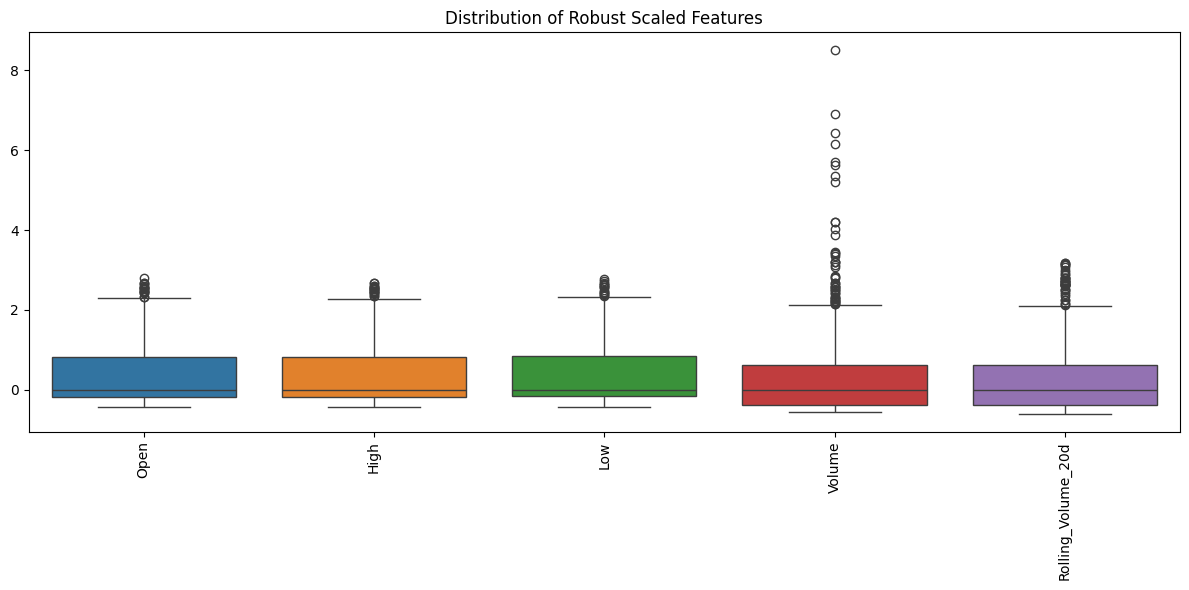

In [ ]:
# 7.6. Robust Scaling (for outlier-sensitive data)
print("\n7.6. Applying Robust Scaling")

# Initialize and fit scaler
robust_scaler = RobustScaler()
X_train_robust = pd.DataFrame(
    robust_scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_valid_robust = pd.DataFrame(
    robust_scaler.transform(X_valid),
    columns=X_valid.columns,
    index=X_valid.index
)

# Check the scaled data
print("Robust scaled training data statistics:")
print(X_train_robust.describe().T[['mean', 'std', 'min', 'max']].head())

# Visualize a sample of robust scaled features
plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train_robust[cols_to_plot])
plt.title('Distribution of Robust Scaled Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


7.7. Comparing Scaling Methods


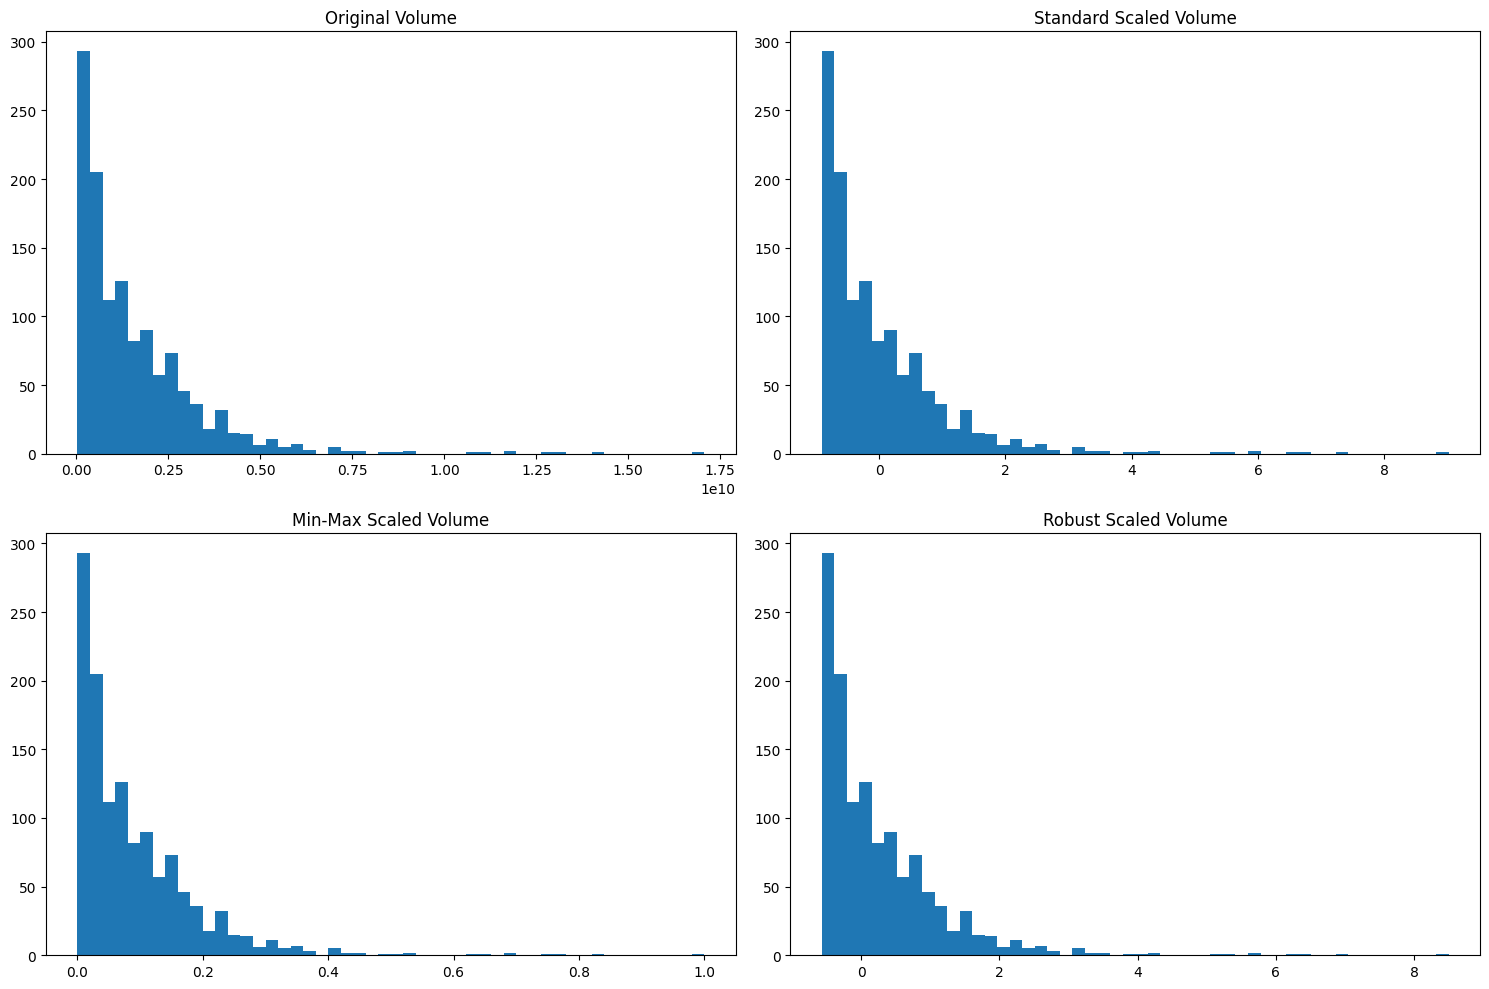

In [ ]:
# 7.7. Compare scaling methods for a sample feature
print("\n7.7. Comparing Scaling Methods")

# Choose a feature with some outliers (e.g., Volume or a momentum feature)
# For demonstration, let's take 'Volume' or a derived feature
sample_feature = 'Volume' if 'Volume' in X_train.columns else X_train.columns[0]

plt.figure(figsize=(15, 10))

# Original data
plt.subplot(2, 2, 1)
plt.hist(X_train[sample_feature], bins=50)
plt.title(f'Original {sample_feature}')

# Standard scaled
plt.subplot(2, 2, 2)
plt.hist(X_train_std[sample_feature], bins=50)
plt.title(f'Standard Scaled {sample_feature}')

# Min-max scaled
plt.subplot(2, 2, 3)
plt.hist(X_train_minmax[sample_feature], bins=50)
plt.title(f'Min-Max Scaled {sample_feature}')

# Robust scaled
plt.subplot(2, 2, 4)
plt.hist(X_train_robust[sample_feature], bins=50)
plt.title(f'Robust Scaled {sample_feature}')

plt.tight_layout()
plt.show()

In [ ]:
# 7.8. Check for potential issues after scaling
print("\n7.8. Checking for issues after scaling")

# Check for NaNs in scaled data
print("NaN values after Standard scaling:", X_train_std.isna().sum().sum())
print("NaN values after Min-Max scaling:", X_train_minmax.isna().sum().sum())
print("NaN values after Robust scaling:", X_train_robust.isna().sum().sum())

# Check for infinity values
print("Infinity values after Standard scaling:", np.isinf(X_train_std).sum().sum())
print("Infinity values after Min-Max scaling:", np.isinf(X_train_minmax).sum().sum())
print("Infinity values after Robust scaling:", np.isinf(X_train_robust).sum().sum())


7.8. Checking for issues after scaling
NaN values after Standard scaling: 5366
NaN values after Min-Max scaling: 5366
NaN values after Robust scaling: 5366
Infinity values after Standard scaling: 0
Infinity values after Min-Max scaling: 0
Infinity values after Robust scaling: 0


In [ ]:
# 7.9. Decide which scaling method to use based on the results
print("\n7.9. Scaling Method Recommendation")

# For cryptocurrency data with potential outliers, robust scaling is often preferable
print("Based on the visualization and feature characteristics:")
print("1. For features with normal distribution: Standard Scaling is appropriate")
print("2. For features with outliers: Robust Scaling is recommended")
print("3. For features that should be bounded between 0-1: Min-Max Scaling works best")

# For our crypto time series, a recommendation:
print("\nRECOMMENDATION:")
print("Since cryptocurrency data often contains outliers and extreme price movements,")
print("Robust Scaling is generally recommended as the primary scaling method.")
print("However, for certain models like neural networks that prefer inputs in [0,1],")
print("Min-Max scaling might be preferred.")


7.9. Scaling Method Recommendation
Based on the visualization and feature characteristics:
1. For features with normal distribution: Standard Scaling is appropriate
2. For features with outliers: Robust Scaling is recommended
3. For features that should be bounded between 0-1: Min-Max Scaling works best

RECOMMENDATION:
Since cryptocurrency data often contains outliers and extreme price movements,
Robust Scaling is generally recommended as the primary scaling method.
However, for certain models like neural networks that prefer inputs in [0,1],
Min-Max scaling might be preferred.


In [ ]:
# 7.10. Store the selected scaling method and scaled datasets for the next step
print("\n7.10. Saving the scaled datasets")

# For this example, we'll proceed with Robust Scaling as our primary method
X_train_scaled = X_train_robust.copy()
X_valid_scaled = X_valid_robust.copy()

# Store the scaler for future use (e.g., with test data or when making predictions)
selected_scaler = robust_scaler

print(f"Selected scaling method: Robust Scaling")
print(f"Final training set shape: {X_train_scaled.shape}")
print(f"Final validation set shape: {X_valid_scaled.shape}")



7.10. Saving the scaled datasets
Selected scaling method: Robust Scaling
Final training set shape: (1252, 377)
Final validation set shape: (314, 377)


In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

warnings.filterwarnings('ignore')

In [ ]:
print("\n" + "="*80)
print("STEP 8: STATIONARITY TESTING AND TRANSFORMATION")
print("="*80)


STEP 8: STATIONARITY TESTING AND TRANSFORMATION


In [ ]:
# 8.1. ADF Test for Stationarity on 'Close' price
print("\n8.1. ADF Test for Stationarity on original 'Close' price")

def adf_test(timeseries):
    """Perform Augmented Dickey-Fuller test for stationarity"""
    result = adfuller(timeseries.dropna())
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.4f}')
    # Interpret the result
    if result[1] <= 0.05:
        print("Result: Stationary (Reject null hypothesis of non-stationarity)")
    else:
        print("Result: Non-stationary (Fail to reject null hypothesis of non-stationarity)")
    return result[1] <= 0.05  # Returns True if stationary

# Test original Close price
is_close_stationary = adf_test(df['Close'])


8.1. ADF Test for Stationarity on original 'Close' price
ADF Statistic: -1.8156
p-value: 0.3727
Critical Values:
	1%: -3.4345
	5%: -2.8634
	10%: -2.5678
Result: Non-stationary (Fail to reject null hypothesis of non-stationarity)


In [ ]:
# 8.2. KPSS Test for Stationarity (complementary test)
print("\n8.2. KPSS Test for Stationarity on original 'Close' price")

def kpss_test(timeseries):
    """Perform KPSS test for stationarity"""
    result = kpss(timeseries.dropna(), regression='c')
    print(f'KPSS Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print(f'Critical Values:')
    for key, value in result[3].items():
        print(f'\t{key}: {value:.4f}')
    # Interpret the result
    if result[1] <= 0.05:
        print("Result: Non-stationary (Reject null hypothesis of stationarity)")
    else:
        print("Result: Stationary (Fail to reject null hypothesis of stationarity)")
    return result[1] > 0.05  # Returns True if stationary

# Test original Close price with KPSS
is_close_stationary_kpss = kpss_test(df['Close'])


8.2. KPSS Test for Stationarity on original 'Close' price
KPSS Statistic: 1.7307
p-value: 0.0100
Critical Values:
	10%: 0.3470
	5%: 0.4630
	2.5%: 0.5740
	1%: 0.7390
Result: Non-stationary (Reject null hypothesis of stationarity)


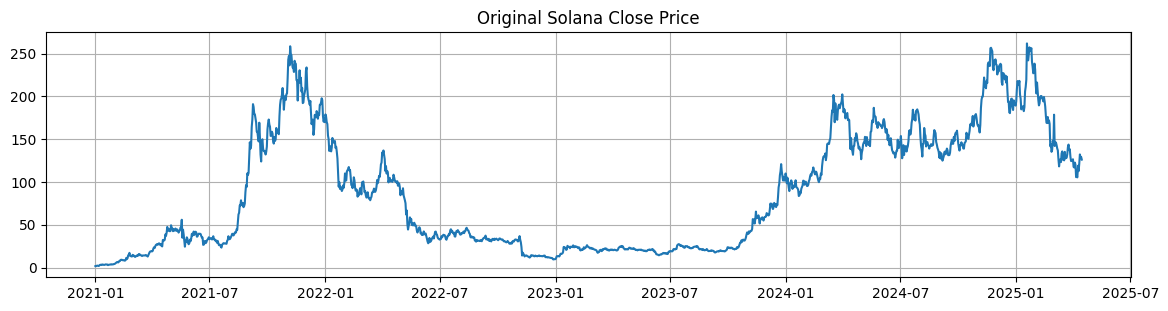

In [ ]:
# 8.3. Visualize the original time series
plt.figure(figsize=(14, 7))
plt.subplot(211)
plt.plot(df['Close'])
plt.title('Original Solana Close Price')
plt.grid(True)


8.4. Applying differencing to achieve stationarity

ADF Test for first difference:
ADF Statistic: -17.6906
p-value: 0.0000
Critical Values:
	1%: -3.4345
	5%: -2.8634
	10%: -2.5678
Result: Stationary (Reject null hypothesis of non-stationarity)


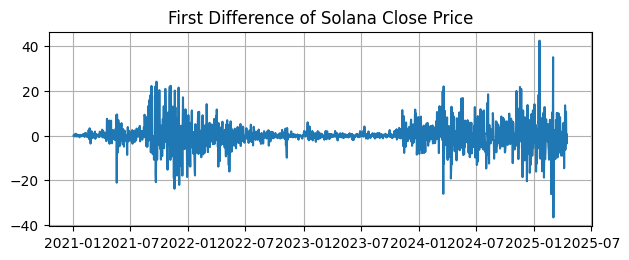

In [ ]:
# 8.4. Apply differencing if needed
print("\n8.4. Applying differencing to achieve stationarity")

# First differencing
df['Close_diff1'] = df['Close'].diff().dropna()

# Test first difference
print("\nADF Test for first difference:")
is_diff1_stationary = adf_test(df['Close_diff1'].dropna())

# Second differencing if needed
if not is_diff1_stationary:
    df['Close_diff2'] = df['Close_diff1'].diff().dropna()
    print("\nADF Test for second difference:")
    is_diff2_stationary = adf_test(df['Close_diff2'].dropna())

# Visualize differenced series
plt.subplot(212)
plt.plot(df['Close_diff1'])
plt.title('First Difference of Solana Close Price')
plt.grid(True)
plt.tight_layout()
plt.show()


8.5. Applying log transformation

ADF Test for log-transformed Close price:
ADF Statistic: -2.6353
p-value: 0.0859
Critical Values:
	1%: -3.4346
	5%: -2.8634
	10%: -2.5678
Result: Non-stationary (Fail to reject null hypothesis of non-stationarity)


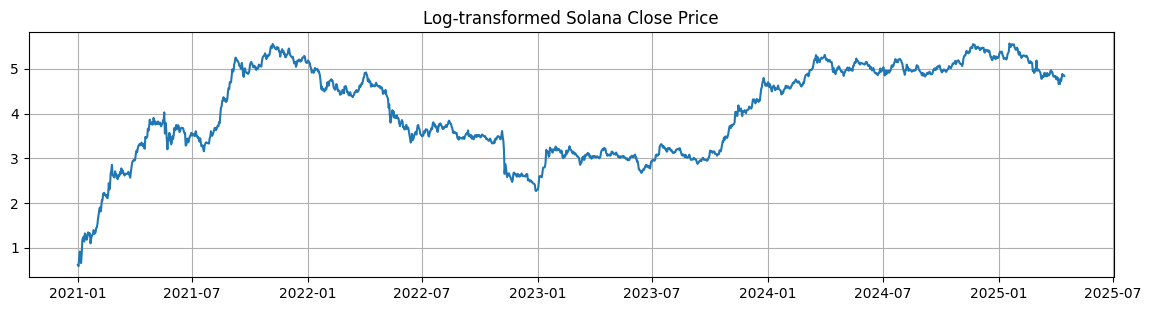

In [ ]:
# 8.5. Log transformation (often useful for financial data)
print("\n8.5. Applying log transformation")

# Add small constant to handle zeros if present
min_close = df['Close'].min()
constant = 0.01 if min_close <= 0 else 0

# Apply log transformation
df['Close_log'] = np.log(df['Close'] + constant)

# Test log-transformed series
print("\nADF Test for log-transformed Close price:")
is_log_stationary = adf_test(df['Close_log'].dropna())

# Visualize log-transformed series
plt.figure(figsize=(14, 7))
plt.subplot(211)
plt.plot(df['Close_log'])
plt.title('Log-transformed Solana Close Price')
plt.grid(True)


ADF Test for first difference of log-transformed Close price:
ADF Statistic: -12.1820
p-value: 0.0000
Critical Values:
	1%: -3.4346
	5%: -2.8634
	10%: -2.5678
Result: Stationary (Reject null hypothesis of non-stationarity)


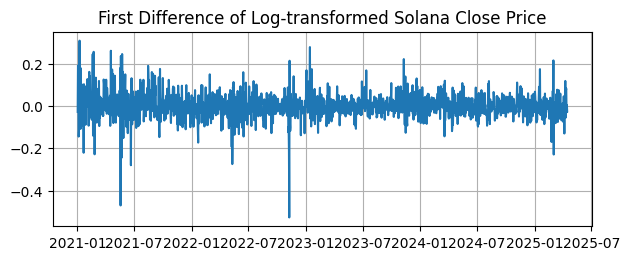

In [ ]:
# 8.6. Differencing log-transformed series if needed
if not is_log_stationary:
    df['Close_log_diff1'] = df['Close_log'].diff().dropna()
    print("\nADF Test for first difference of log-transformed Close price:")
    is_log_diff1_stationary = adf_test(df['Close_log_diff1'].dropna())

    # Visualize differenced log-transformed series
    plt.subplot(212)
    plt.plot(df['Close_log_diff1'])
    plt.title('First Difference of Log-transformed Solana Close Price')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 8.7. Seasonal differencing if needed (uncommon for daily crypto data)
print("\n8.7. Checking for seasonality and seasonal differencing")
print("Note: Daily cryptocurrency data typically doesn't exhibit strong seasonality")
print("but weekly patterns are sometimes observed.")

# Weekly seasonal differencing example (if weekly patterns exist)
df['Close_seasonal_diff7'] = df['Close'].diff(7).dropna()

# Test weekly differenced series
print("\nADF Test for weekly differenced Close price:")
is_seasonal_diff_stationary = adf_test(df['Close_seasonal_diff7'].dropna())


8.7. Checking for seasonality and seasonal differencing
Note: Daily cryptocurrency data typically doesn't exhibit strong seasonality
but weekly patterns are sometimes observed.

ADF Test for weekly differenced Close price:
ADF Statistic: -6.7208
p-value: 0.0000
Critical Values:
	1%: -3.4346
	5%: -2.8634
	10%: -2.5678
Result: Stationary (Reject null hypothesis of non-stationarity)


In [ ]:
# 8.8. Select the most appropriate transformation based on tests
print("\n8.8. Selecting the most appropriate transformation")

# Choose the most stationary transformation
transformations = {
    'Original': is_close_stationary,
    'First Difference': is_diff1_stationary if 'Close_diff1' in df.columns else False,
    'Second Difference': is_diff2_stationary if 'Close_diff2' in df.columns else False,
    'Log Transform': is_log_stationary,
    'Log + First Difference': is_log_diff1_stationary if 'Close_log_diff1' in df.columns else False,
    'Seasonal Difference': is_seasonal_diff_stationary
}

# Find which transformations achieved stationarity
stationary_transformations = [k for k, v in transformations.items() if v]

print("Transformations that achieved stationarity:")
for t in stationary_transformations:
    print(f"- {t}")


8.8. Selecting the most appropriate transformation
Transformations that achieved stationarity:
- First Difference
- Log + First Difference
- Seasonal Difference


In [ ]:
# Recommend the simplest transformation that achieved stationarity
if stationary_transformations:
    # Prioritize simpler transformations
    priority_order = ['Original', 'Log Transform', 'First Difference', 'Seasonal Difference',
                     'Log + First Difference', 'Second Difference']

    for p in priority_order:
        if p in stationary_transformations:
            recommended = p
            break
    else:
        recommended = stationary_transformations[0]  # default to first if none in priority list

    print(f"\nRecommended transformation: {recommended}")

    # Map the transformation to the column name
    transformation_columns = {
        'Original': 'Close',
        'First Difference': 'Close_diff1',
        'Second Difference': 'Close_diff2',
        'Log Transform': 'Close_log',
        'Log + First Difference': 'Close_log_diff1',
        'Seasonal Difference': 'Close_seasonal_diff7'
    }

    selected_target = transformation_columns[recommended]
    print(f"Selected target column for modeling: {selected_target}")
else:
    print("\nWarning: No transformation achieved stationarity according to both tests.")
    print("Proceeding with first differencing as a default transformation.")
    selected_target = 'Close_diff1'

# Store the selected target column for later use
df['selected_target'] = df[selected_target]



Recommended transformation: First Difference
Selected target column for modeling: Close_diff1


In [ ]:
print("\n" + "="*80)
print("STEP 9: AUTOCORRELATION ANALYSIS")
print("="*80)



STEP 9: AUTOCORRELATION ANALYSIS


In [ ]:
# 9.1. Calculate ACF (Autocorrelation Function)
print("\n9.1. Calculating ACF for the selected target")

target_data = df['selected_target'].dropna()
lags = min(40, len(target_data) // 10)  # Use 40 lags or 10% of data length, whichever is smaller

# Calculate ACF values
acf_values = acf(target_data, nlags=lags, fft=True)
print(f"ACF calculation complete. Shape: {acf_values.shape}")


9.1. Calculating ACF for the selected target
ACF calculation complete. Shape: (41,)


In [ ]:
# 9.2. Calculate PACF (Partial Autocorrelation Function)
print("\n9.2. Calculating PACF for the selected target")

# Calculate PACF values
pacf_values = pacf(target_data, nlags=lags)
print(f"PACF calculation complete. Shape: {pacf_values.shape}")



9.2. Calculating PACF for the selected target
PACF calculation complete. Shape: (41,)


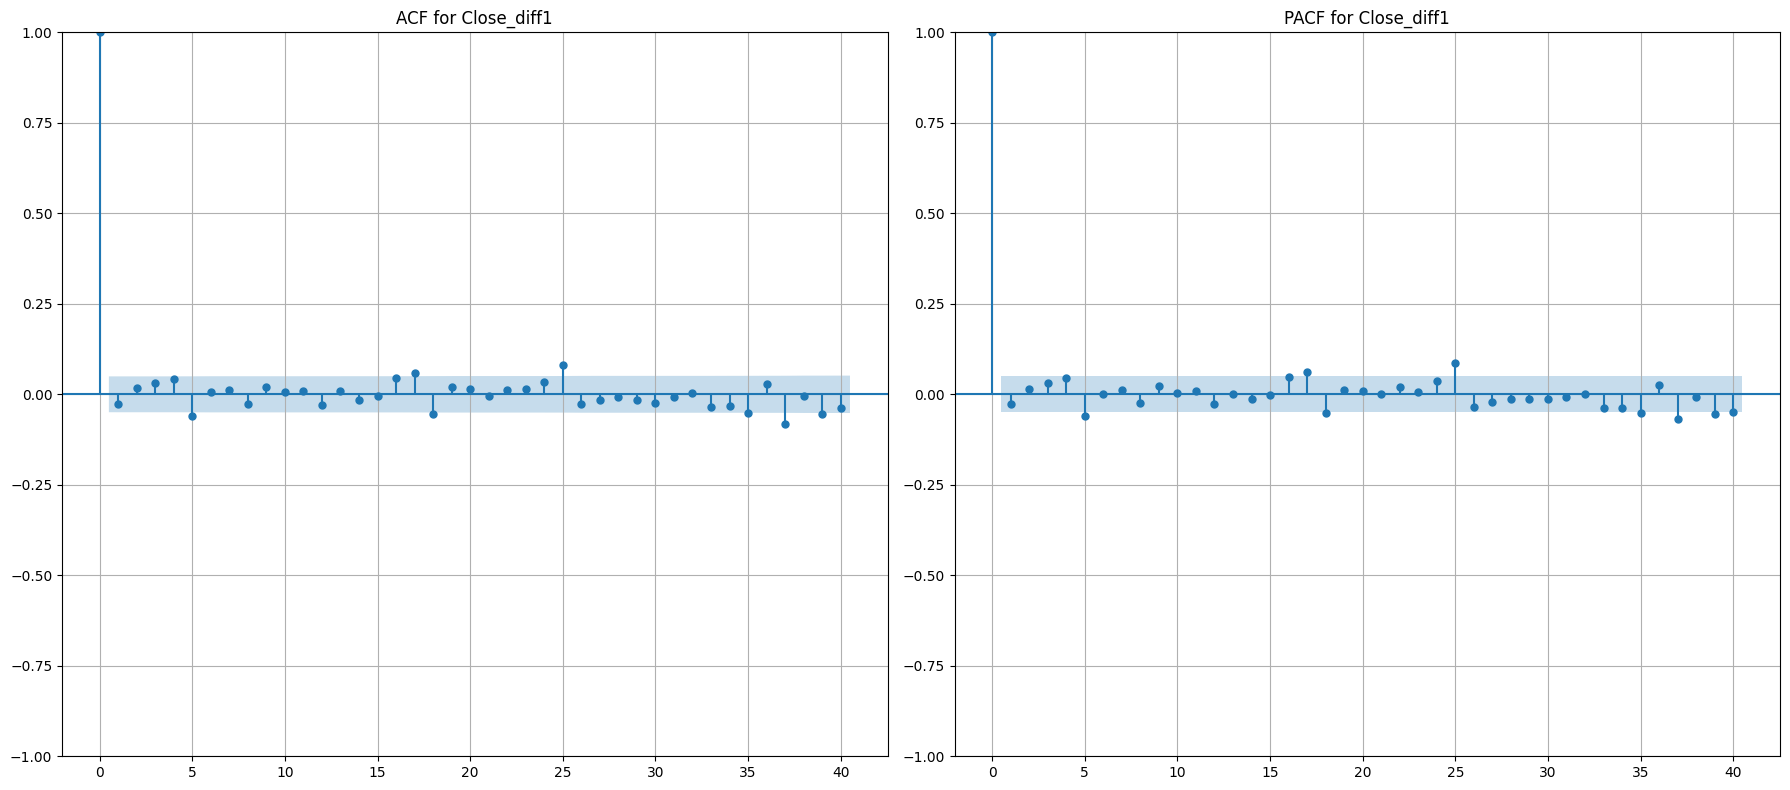

In [ ]:
# 9.3. Plot ACF and PACF
plt.figure(figsize=(18, 8))

# ACF plot
plt.subplot(121)
plot_acf(target_data, lags=lags, ax=plt.gca(), title=f'ACF for {selected_target}', alpha=0.05)
plt.grid(True)

# PACF plot
plt.subplot(122)
plot_pacf(target_data, lags=lags, ax=plt.gca(), title=f'PACF for {selected_target}', alpha=0.05)
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 9.4. Identify significant lags for feature selection
print("\n9.4. Identifying significant lags from ACF and PACF")

# Calculate confidence interval (95%)
confidence_interval = 1.96 / np.sqrt(len(target_data))

# Find significant ACF lags
significant_acf_lags = [i for i, v in enumerate(acf_values) if abs(v) > confidence_interval and i > 0]
print(f"Significant ACF lags: {significant_acf_lags[:10]}{'...' if len(significant_acf_lags) > 10 else ''}")

# Find significant PACF lags
significant_pacf_lags = [i for i, v in enumerate(pacf_values) if abs(v) > confidence_interval and i > 0]
print(f"Significant PACF lags: {significant_pacf_lags[:10]}{'...' if len(significant_pacf_lags) > 10 else ''}")



9.4. Identifying significant lags from ACF and PACF
Significant ACF lags: [5, 17, 18, 25, 35, 37, 39]
Significant PACF lags: [5, 17, 18, 25, 35, 37, 39, 40]


In [ ]:
# 9.5. Suggest ARIMA orders based on ACF/PACF
print("\n9.5. Suggesting ARIMA orders based on ACF/PACF patterns")

# Simple heuristic for AR and MA orders
p_order = max(significant_pacf_lags) if significant_pacf_lags else 0
q_order = max(significant_acf_lags) if significant_acf_lags else 0

# Calculate d_order based on differencing needed
if selected_target == 'Close':
    d_order = 0
elif selected_target in ['Close_diff1', 'Close_log_diff1', 'Close_seasonal_diff7']:
    d_order = 1
elif selected_target == 'Close_diff2':
    d_order = 2
else:
    d_order = 0

print(f"Suggested ARIMA orders based on ACF/PACF analysis:")
print(f"p (AR order): {p_order}")
print(f"d (Differencing): {d_order}")
print(f"q (MA order): {q_order}")
print(f"Suggested ARIMA({p_order},{d_order},{q_order})")


9.5. Suggesting ARIMA orders based on ACF/PACF patterns
Suggested ARIMA orders based on ACF/PACF analysis:
p (AR order): 40
d (Differencing): 1
q (MA order): 39
Suggested ARIMA(40,1,39)


In [ ]:
# 9.6. Create lagged features based on significant lags
print("\n9.6. Creating lagged features based on significant autocorrelations")

# Combine significant lags from both ACF and PACF
all_significant_lags = sorted(list(set(significant_acf_lags + significant_pacf_lags)))
print(f"All significant lags to use as features: {all_significant_lags[:10]}{'...' if len(all_significant_lags) > 10 else ''}")

# Cap the number of lags to avoid excessive features
max_lags = 20
if len(all_significant_lags) > max_lags:
    print(f"Limiting to top {max_lags} lags for feature creation")
    all_significant_lags = all_significant_lags[:max_lags]

# Create lagged features based on significant lags
for lag in all_significant_lags:
    col_name = f'{selected_target}_lag{lag}'
    df[col_name] = df['selected_target'].shift(lag)

print(f"Created {len(all_significant_lags)} new lagged features based on autocorrelation analysis")


9.6. Creating lagged features based on significant autocorrelations
All significant lags to use as features: [5, 17, 18, 25, 35, 37, 39, 40]
Created 8 new lagged features based on autocorrelation analysis


In [ ]:
df.head()

,Open,High,Low,Close,Volume,Rolling_Volume_20d,Returns,Returns_Abs,Volatility_14d,Volume_Ratio,...,Close_seasonal_diff7,selected_target,Close_diff1_lag5,Close_diff1_lag17,Close_diff1_lag18,Close_diff1_lag25,Close_diff1_lag35,Close_diff1_lag37,Close_diff1_lag39,Close_diff1_lag40
date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,1.510,1.865,1.495,1.847,25722549.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02 00:00:00+00:00,1.847,2.012,1.752,1.799,31671064.0,NaN,-0.025988,0.025988,NaN,NaN,...,NaN,-0.048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-03 00:00:00+00:00,1.799,2.808,2.007,2.185,55073422.0,NaN,0.214564,0.214564,NaN,NaN,...,NaN,0.386,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-04 00:00:00+00:00,2.185,2.573,2.066,2.491,59955405.0,NaN,0.140046,0.140046,NaN,NaN,...,NaN,0.306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05 00:00:00+00:00,2.491,2.634,2.145,2.158,50555207.0,NaN,-0.133681,0.133681,NaN,NaN,...,NaN,-0.333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print("\n" + "="*80)
print("STEP 10: FEATURE SELECTION")
print("="*80)



STEP 10: FEATURE SELECTION


In [ ]:
# 10.1. Prepare the dataset for feature selection
print("\n10.1. Preparing dataset for feature selection")

# Use our selected target and drop rows with NaN values
y = df['selected_target'].dropna()
X = df.drop(columns=['selected_target']).loc[y.index]

# Drop target-related columns and datetime index to avoid data leakage
target_related_cols = [col for col in X.columns if 'Close' in col]
X = X.drop(columns=target_related_cols, errors='ignore')

# Convert index to features if useful
X['day_of_week'] = X.index.dayofweek
X['day_of_month'] = X.index.day
X['month'] = X.index.month

# Drop any remaining NaN values
X = X.dropna(axis=1)  # Drop columns with any NaN
y = y.loc[X.index]  # Align y with X

print(f"Dataset prepared: X shape = {X.shape}, y shape = {y.shape}")


10.1. Preparing dataset for feature selection
Dataset prepared: X shape = (1565, 129), y shape = (1565,)


In [ ]:
# 10.2. Filter-based feature selection (correlation)
print("\n10.2. Filter-based feature selection (correlation)")

# Calculate correlation with target
correlation_with_target = X.corrwith(y).abs().sort_values(ascending=False)

# Display top correlated features
print("Top 20 features by correlation with target:")
print(correlation_with_target.head(20))

# Create a correlation threshold
correlation_threshold = 0.3
high_corr_features = correlation_with_target[correlation_with_target > correlation_threshold].index.tolist()
print(f"\nFeatures with correlation > {correlation_threshold}: {len(high_corr_features)}")
print(f"Sample high correlation features: {high_corr_features[:5]}{'...' if len(high_corr_features) > 5 else ''}")



10.2. Filter-based feature selection (correlation)
Top 20 features by correlation with target:
Returns_BoxCox        0.730911
Returns_Robust        0.728578
Returns_MinMax        0.728578
Returns               0.728578
Returns_Zscore        0.728578
Higher_High           0.369642
Lower_Low             0.341956
MACD_Hist_MinMax      0.193553
MACD_Hist_Robust      0.193553
MACD_Hist_Zscore      0.193553
MACD_Hist             0.193553
RSI_Overbought        0.188503
Extreme_Move          0.148035
Price_Above_SMA_50    0.127416
RSI_Oversold          0.121136
Returns_Abs_Zscore    0.093706
Returns_Abs_Robust    0.093706
Returns_Abs_MinMax    0.093706
Returns_Abs           0.093706
MACD_Line             0.081650
dtype: float64

Features with correlation > 0.3: 7
Sample high correlation features: ['Returns_BoxCox', 'Returns_Robust', 'Returns_MinMax', 'Returns', 'Returns_Zscore']...


In [ ]:
# 10.3. Mutual Information for non-linear relationships
print("\n10.3. Mutual Information for non-linear relationships")

# Calculate mutual information scores (handle possible errors)
try:
    X_scaled = StandardScaler().fit_transform(X)
    mi_scores = mutual_info_regression(X_scaled, y)
    mi_scores = pd.Series(mi_scores, index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    # Display top features by mutual information
    print("Top 20 features by mutual information:")
    print(mi_scores.head(20))

    # Select top features by mutual information
    mi_threshold = np.percentile(mi_scores, 70)  # Top 30% of features
    high_mi_features = mi_scores[mi_scores > mi_threshold].index.tolist()
    print(f"\nTop 30% features by mutual information: {len(high_mi_features)}")
    print(f"Sample high MI features: {high_mi_features[:5]}{'...' if len(high_mi_features) > 5 else ''}")
except Exception as e:
    print(f"Error calculating mutual information: {e}")
    high_mi_features = []



10.3. Mutual Information for non-linear relationships
Top 20 features by mutual information:
Returns_BoxCox        1.394061
Returns_Robust        1.392086
Returns_Zscore        1.392086
Returns_MinMax        1.392086
Returns               1.392073
Returns_Abs_Zscore    0.713890
Returns_Abs           0.713877
Returns_Abs_Robust    0.713877
Returns_Abs_MinMax    0.713858
Volume_BoxCox         0.403001
Volume_Log            0.402110
Log_Volume_MinMax     0.402110
Log_Volume_Robust     0.402110
Log_Volume            0.402110
Log_Volume_Zscore     0.402110
Volume_MinMax         0.392841
Volume                0.392841
Volume_Robust         0.392841
Volume_Zscore         0.392841
EMA_20_MinMax         0.346204
dtype: float64

Top 30% features by mutual information: 39
Sample high MI features: ['Returns_BoxCox', 'Returns_Robust', 'Returns_Zscore', 'Returns_MinMax', 'Returns']...


In [ ]:
# 10.4. Combine feature selection methods
print("\n10.4. Combining feature selection methods")

# Combine high correlation and high mutual information features
if high_mi_features:
    selected_features = list(set(high_corr_features + high_mi_features))
else:
    selected_features = high_corr_features

print(f"Combined selected features: {len(selected_features)}")

# If we have too many features, apply SelectKBest
max_features = 100  # Maximum number of features to keep
if len(selected_features) > max_features:
    print(f"\nToo many features ({len(selected_features)}). Reducing to {max_features} using SelectKBest")

    # Apply SelectKBest
    selector = SelectKBest(f_regression, k=max_features)
    X_selected = selector.fit_transform(X[selected_features], y)

    # Get selected feature names
    selected_mask = selector.get_support()
    selected_features = [selected_features[i] for i in range(len(selected_features)) if selected_mask[i]]

    print(f"Final number of features after SelectKBest: {len(selected_features)}")



10.4. Combining feature selection methods
Combined selected features: 41



10.5. Visualizing feature importance


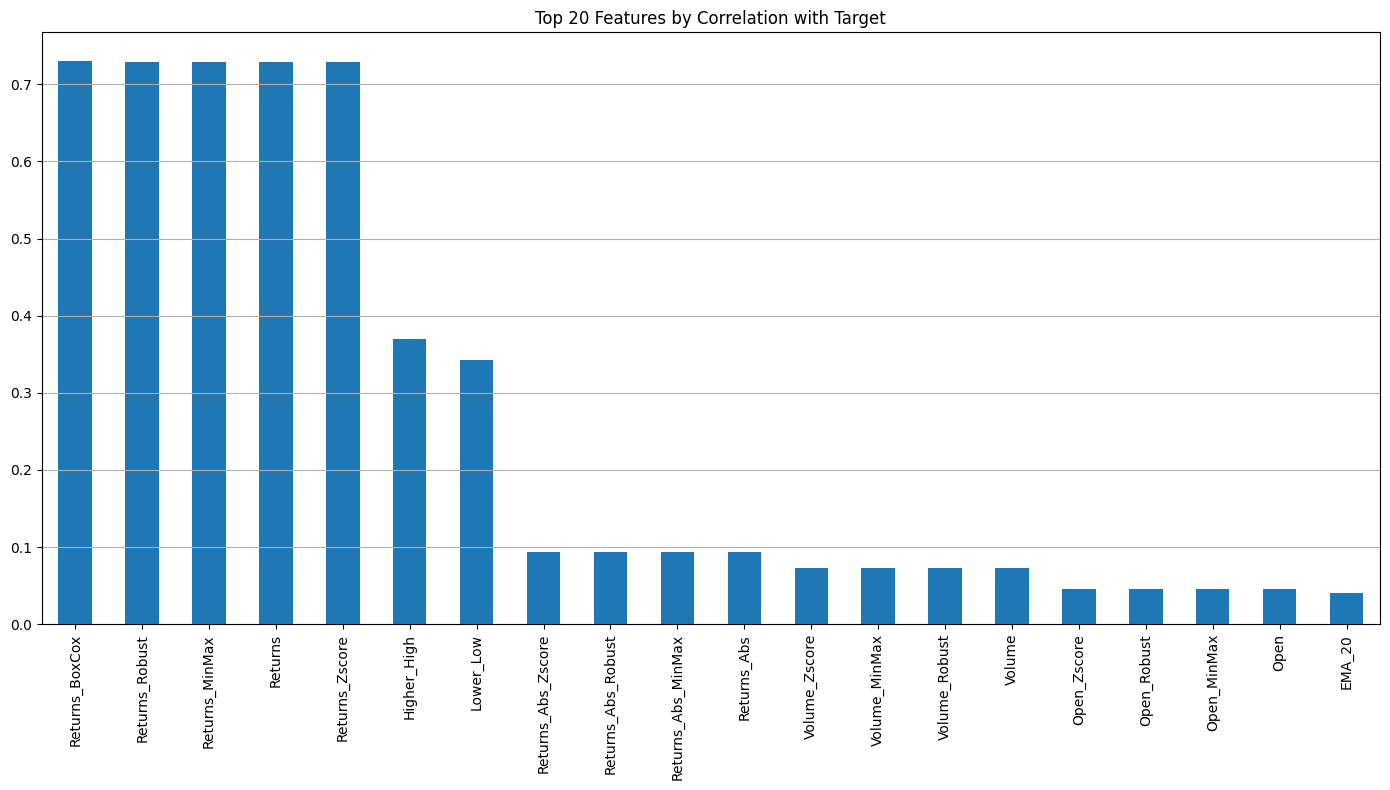

In [ ]:
# 10.5. Feature importance visualization
print("\n10.5. Visualizing feature importance")

# Plot top 20 features by correlation
plt.figure(figsize=(14, 8))
correlation_with_target[selected_features].sort_values(ascending=False).head(20).plot(kind='bar')
plt.title('Top 20 Features by Correlation with Target')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [ ]:
# 10.6. PCA for dimensionality reduction (if needed)
print("\n10.6. PCA for dimensionality reduction")

# Decide whether to use PCA based on number of features
if len(selected_features) > 50:
    print(f"Large number of features ({len(selected_features)}). Applying PCA.")

    # Apply PCA
    X_selected = X[selected_features]
    X_scaled = StandardScaler().fit_transform(X_selected)

    pca = PCA(n_components=0.95)  # Retain 95% of variance
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA reduced dimensions from {X_scaled.shape[1]} to {X_pca.shape[1]}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

    # Plot explained variance
    plt.figure(figsize=(12, 6))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.title('PCA Explained Variance')
    plt.tight_layout()
    plt.show()

    # Store PCA result
    use_pca = True
    n_components = X_pca.shape[1]
else:
    print(f"Using {len(selected_features)} selected features without PCA.")
    use_pca = False
    X_selected = X[selected_features]


10.6. PCA for dimensionality reduction
Using 41 selected features without PCA.


In [ ]:
# 10.7. Final dataset with selected features
print("\n10.7. Preparing final dataset with selected features")

if use_pca:
    print(f"Final dataset uses PCA with {n_components} components")
    # We'll need to store the PCA and StandardScaler objects for later transformation
    final_X = pd.DataFrame(X_pca, index=X.index)
    # Create column names for PCA components
    final_X.columns = [f'PC{i+1}' for i in range(n_components)]
else:
    print(f"Final dataset uses {len(selected_features)} original features")
    final_X = X[selected_features]

final_y = y

print(f"Final dataset: X shape = {final_X.shape}, y shape = {final_y.shape}")
print(f"First 5 columns: {final_X.columns[:5]}")


10.7. Preparing final dataset with selected features
Final dataset uses 41 original features
Final dataset: X shape = (1565, 41), y shape = (1565,)
First 5 columns: Index(['Open_Robust', 'Volume_MinMax', 'EMA_20_MinMax', 'Open_MinMax',
       'High_Zscore'],
      dtype='object')


In [ ]:
final_y.head()
final_y.to_csv('/content/drive/MyDrive/Crypto-data-v2/final_y.csv', index=True)


In [ ]:
final_X.head()
final_X.to_csv('/content/drive/MyDrive/Crypto-data-v2/final_X.csv', index=True)


In [ ]:
print("\n" + "="*80)
print("STEP 11: WINDOW CREATION")
print("="*80)


STEP 11: WINDOW CREATION


In [ ]:
# 11.1. Define window parameters
print("\n11.1. Defining window parameters")

# For time series forecasting
# input_window_size = max(all_significant_lags) if all_significant_lags else 10
# forecast_horizon = 1  # Predict next day's price

# print(f"Input window size: {input_window_size} days")
# print(f"Forecast horizon: {forecast_horizon} day(s)")

# 11.1. Define key parameters for TFT
lookback_window = 30  # Number of past time steps to use for context
forecast_horizon = 7  # Number of future time steps to predict
max_prediction_length = 1


11.1. Defining window parameters
Input window size: 40 days
Forecast horizon: 1 day(s)


In [ ]:
# 11.2. Prepare the dataset with appropriate features
# Load your processed dataset with the 41 selected features
# Assuming df_selected is your dataframe with the 41 selected features
df_selected = final_X

In [ ]:
# 11.3. Categorize features by type (required for TFT)
# These need to be adjusted based on your specific 41 features
static_features = []  # Features that don't change over time
time_varying_known_features = [col for col in df_selected.columns if col not in ['Close_diff1'] + static_features]
time_varying_unknown_features = []

# Target variable
target = 'Close_diff1'  # First difference of Close price

print(f"Static features: {len(static_features)}")
print(f"Time-varying known features: {len(time_varying_known_features)}")
print(f"Time-varying unknown features: {len(time_varying_unknown_features)}")
print(f"Target variable: {target}")

Static features: 0
Time-varying known features: 41
Time-varying unknown features: 0
Target variable: Close_diff1


In [ ]:
 #11.4. Create time-based training, validation, and test splits
# Using chronological splits appropriate for time series forecasting
test_size = 0.1
val_size = 0.1
train_size = 1 - test_size - val_size

# Calculate split points
n = len(df_selected)
train_end = int(n * train_size)
val_end = int(n * (train_size + val_size))

# Split the data
train_data = df_selected.iloc[:train_end]
val_data = df_selected.iloc[train_end:val_end]
test_data = df_selected.iloc[val_end:]

print(f"Training data: {train_data.shape}")
print(f"Validation data: {val_data.shape}")
print(f"Test data: {test_data.shape}")

In [ ]:
# 11.5. Function to create sliding windows appropriate for TFT
def create_tft_dataset(data, lookback, horizon, target_col):
    """
    Create sliding windows for TFT model:
    - X: Features with lookback window
    - y: Target values for forecast horizon
    """
    X, y = [], []

    for i in range(lookback, len(data) - horizon + 1):
        # Extract lookback window for features
        X.append(data.iloc[i-lookback:i].values)

        # Extract forecast horizon for target
        y.append(data[target_col].iloc[i:i+horizon].values)

    return np.array(X), np.array(y)

In [ ]:
# 11.2. Create sliding window sequences
print("\n11.2. Creating sliding window sequences")

def create_windows(data, window_size, forecast_horizon):
    """Create sliding window sequences from time series data"""
    X, y = [], []
    for i in range(len(data) - window_size - forecast_horizon + 1):
        X.append(data.iloc[i:i+window_size].values)
        y.append(data.iloc[i+window_size:i+window_size+forecast_horizon].values)
    return np.array(X), np.array(y)

# Ensure data is sorted by date
final_X_sorted = final_X.sort_index()
final_y_sorted = final_y.sort_index()

# For traditional ML models, create lagged features
print("\n11.2.1. Creating lagged features for traditional ML models")
X_lagged = pd.DataFrame(index=final_X_sorted.index)

for i in range(1, input_window_size + 1):
    for col in final_X_sorted.columns:
        X_lagged[f'{col}_lag{i}'] = final_X_sorted[col].shift(i)

# Align X_lagged with y by dropping NaN rows
X_lagged = X_lagged.dropna()
y_aligned = final_y_sorted.loc[X_lagged.index]

print(f"Traditional ML dataset: X shape = {X_lagged.shape}, y shape = {y_aligned.shape}")

# For sequence models (RNN, LSTM), create 3D windows
print("\n11.2.2. Creating 3D windows for sequence models")
# Use only features from final_X for sequence windows
X_windows, y_windows = create_windows(final_X_sorted, input_window_size, forecast_horizon)

print(f"Sequence model dataset: X shape = {X_windows.shape}, y shape = {y_windows.shape}")


In [ ]:
# 11.3. Split into training and validation sets
print("\n11.3. Splitting into training and validation sets")

# For traditional ML
train_size = int(len(X_lagged) * 0.8)
X_train_ml = X_lagged.iloc[:train_size]
X_valid_ml = X_lagged.iloc[train_size:]
y_train_ml = y_aligned.iloc[:train_size]
y_valid_ml = y_aligned.iloc[train_size:]

print(f"ML Training set: X shape = {X_train_ml.shape}, y shape = {y_train_ml.shape}")
print(f"ML Validation set: X shape = {X_valid_ml.shape}, y shape = {y_valid_ml.shape}")

# For sequence models
train_size_seq = int(len(X_windows) * 0.8)
X_train_seq = X_windows[:train_size_seq]
X_valid_seq = X_windows[train_size_seq:]
y_train_seq = y_windows[:train_size_seq]
y_valid_seq = y_windows[train_size_seq:]

print(f"Sequence Training set: X shape = {X_train_seq.shape}, y shape = {y_train_seq.shape}")
print(f"Sequence Validation set: X shape = {X_valid_seq.shape}, y shape = {y_valid_seq.shape}")

In [ ]:
# 11.4. Prepare for different model types
print("\n11.4. Preparing datasets for different model types")

# For traditional ML models (already prepared above)
print("Traditional ML models (Linear Regression, XGBoost, etc.):")
print(f"- X_train shape: {X_train_ml.shape}")
print(f"- y_train shape: {y_train_ml.shape}")

# For RNN/LSTM models (already prepared above)
print("\nRNN/LSTM models:")
print(f"- X_train shape: {X_train_seq.shape}")
print(f"- y_train shape: {y_train_seq.shape}")

# For Time Series specific models like ARIMA
print("\nARIMA/SARIMA models:")
print(f"- Training data length: {len(final_y_sorted[:train_size])}")
print(f"- Test data length: {len(final_y_sorted[train_size:])}")
print(f"- Suggested ARIMA orders: ({p_order},{d_order},{q_order})")

In [ ]:
# 11.5. Visualize the training and validation split
print("\n11.5. Visualizing the train/validation split")

plt.figure(figsize=(15, 6))
plt.plot(final_y_sorted.index[:train_size], final_y_sorted[:train_size], label='Training Data')
plt.plot(final_y_sorted.index[train_size:], final_y_sorted[train_size:], label='Validation Data', color='red')
plt.axvline(final_y_sorted.index[train_size], color='black', linestyle='--')
plt.title(f'Train/Validation Split for {selected_target}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 11.6. Save the processed datasets
print("\n11.6. Final processed datasets ready for modeling")

# Summary of all prepared datasets
print("\nDatasets ready for modeling:")
print("1. Traditional ML:")
print(f"   - X_train_ml: {X_train_ml.shape}")
print(f"   - X_valid_ml: {X_valid_ml.shape}")
print(f"   - y_train_ml: {y_train_ml.shape}")
print(f"   - y_valid_ml: {y_valid_ml.shape}")

print("\n2. Sequence Models (RNN/LSTM):")
print(f"   - X_train_seq: {X_train_seq.shape}")
print(f"   - X_valid_seq: {X_valid_seq.shape}")
print(f"   - y_train_seq: {y_train_seq.shape}")
print(f"   - y_valid_seq: {y_valid_seq.shape}")

print("\n3. Time Series Models (ARIMA):")
print(f"   - Training series length: {len(final_y_sorted[:train_size])}")
print(f"   - Validation series length: {len(final_y_sorted[train_size:])}")

print("\nAll preprocessing steps completed successfully!")